# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `***.csv` — информация о договоре;
- `***.csv` — персональные данные клиента;
- `***.csv` — информация об интернет-услугах;
- `***.csv` — информация об услугах телефонии.

*BeginDate* - дата начала пользования услугами,   
*EndDate* - дата окончания пользования услугами,  
*Type* - тип оплаты: ежемесячный, годовой и тд,  
*PaperlessBilling* - безналичный расчет,  
*PaymentMethod* - способ оплаты,  
*MonthlyCharges* - ежемесячные траты на услуги,  
*TotalCharges* - всего потрачено денег на услуги   

*gender* - пол клиента,  
*Senior Citizen* - наличие пенсионного статуса по возрасту,  
*Partner* - наличие супруга(и),  
*Dependents* - наличие иждивенцев  

*InternetService* - тип интенета: DSL, Fiber optic,  
*OnlineSecurity* - онлайн безопасность,  
*OnlineBackup* - резервное копирование,  
*DeviceProtection* - защитное устройство,  
*TechSupport* - техподдержка,  
*StreamingTV* - стримминговое ТВ,  
*StreamingMovies* - стримминговые фильмы  

*MultipleLines* - наличие возможности ведения параллельных линий во время звонка  

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020. Данные находятся в папке /datasets/.

**Целевая метрика**

Нашей метрикой качества будет ROC_AUC. ROC_AUC необходимо получить >= 0.85, дополнительная метрика Accuracy.

## Исследовательский анализ данных

### Загрузка данных и подключение библиотек

In [1]:
import re
import time
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

STATE=240423
TEST_SIZE=0.25

warnings.filterwarnings("ignore")

In [2]:
!pip install pandas-profiling -q

import phik
from phik.report import plot_correlation_matrix

In [3]:
!pip install shap -q

import shap

In [4]:
try:
    contract = pd.read_csv("/***/***.csv")
    personal = pd.read_csv("/***/***.csv")
    internet = pd.read_csv("/***/***.csv")
    phone = pd.read_csv("/***/***.csv")
except:
    contract = pd.read_csv("***.csv")
    personal = pd.read_csv("***.csv")
    internet = pd.read_csv("***.csv")
    phone = pd.read_csv("***.csv")

### Обзор данных

In [5]:
def information (df, name_df):
    print("=" * 48, "Обзор датафрейма", name_df, "=" * 48)
    print("\n", "Первые пять строк", "-" * 102)
    display(df.head())
    print("\n", "Основная информация", "-" * 100, "\n")
    df.info()
    print("\n" * 2, "Список характерных значений", "-" * 92)
    display(df.describe())
    print("В наборе данных", name_df, "количество явных дубликатов:", df.duplicated().sum(), 
          ", пропусков:", df.isna().sum().sum(), "\n")
    print("=" * 121)

In [6]:
information (contract, "contract")

================================================ Обзор датафрейма contract ================================================

 Первые пять строк ------------------------------------------------------------------------------------------------------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



 Основная информация ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


 Список характерных значений --------------------------------------------------------------------------------------------


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


В наборе данных contract количество явных дубликатов: 0 , пропусков: 0 



In [7]:
information (personal, "personal")

================================================ Обзор датафрейма personal ================================================

 Первые пять строк ------------------------------------------------------------------------------------------------------


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



 Основная информация ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


 Список характерных значений --------------------------------------------------------------------------------------------


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


В наборе данных personal количество явных дубликатов: 0 , пропусков: 0 



In [8]:
information (internet, "internet")

================================================ Обзор датафрейма internet ================================================

 Первые пять строк ------------------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



 Основная информация ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


 Список характерных значений --------------------------------------------------------------------------------------------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,0980-FEXWF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


В наборе данных internet количество явных дубликатов: 0 , пропусков: 0 



In [9]:
information (phone, "phone")

================================================ Обзор датафрейма phone ================================================

 Первые пять строк ------------------------------------------------------------------------------------------------------


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



 Основная информация ---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


 Список характерных значений --------------------------------------------------------------------------------------------


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7503-EPSZW,No
freq,1,3390


В наборе данных phone количество явных дубликатов: 0 , пропусков: 0 



Явные дубликаты в датасетах отсутствуют, проверим, что в данных о контрактах и клиентах нет дубликатов по уникальному номеру клиента, в остальных датасетах таких дубликатов нет. Установим столбец с уникальным номером клиента в качестве индекса.

In [10]:
len(contract["customerID"].unique()) == contract.shape[0] and len(personal["customerID"].unique()) == personal.shape[0]

True

In [11]:
contract = contract.set_index("customerID")
personal = personal.set_index("customerID")
internet = internet.set_index("customerID")
phone = phone.set_index("customerID")

Приведем названия столбцов к "змеиному" регистру.

In [12]:
# этот столбец назван по иному принципу, чем остальные, сначала я переименую его вручную
internet.rename(columns = {"StreamingTV": "StreamingTv"}, inplace = True )

def ren_col (df, ren_df):
    for col in df.columns:
        col_list = list(col)
        [col_list.insert(x,"_") for x in [let.start() for let in re.finditer("[A-Z]",col)][:0:-1]]
        ren_df[col] = "".join(col_list).lower()
    df.rename(columns = ren_df, inplace = True )

ren_col (contract, {})
ren_col (personal, {})
ren_col (internet, {})
ren_col (phone, {})

Пропусков в данных сейчас нет, но в датасетах о интернет-услугах и телефонии, данных меньше, чем клиентов и их контрактов, у оператора два основных вида услуг и не все клиенты пользуются ими вместе, следовательно, при объединении наборов данных появятся пропуски, которые будут заполнены как отсутствие подключенной услуги. Объединим таблицы в одну для удобства дальнейшего анализа, чтобы мы видели полную картину в данных.

In [13]:
# используем join, индекс во всех таблицах - это ID клиента
full_data = contract.join(personal, how="left").join(internet, how="left").join(phone, how="left")

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

### Предварительный анализ данных

Посмотрим какие уникальные значения есть в категориальных столбцах.

In [14]:
cat = ["type", "paperless_billing", "payment_method", "gender", "senior_citizen",
       "partner", "dependents", "internet_service", "online_security",
       "online_backup", "device_protection", "tech_support", "streaming_tv",
       "streaming_movies", "multiple_lines"]

In [15]:
print("Уникальные значения столбцов:")
for col in cat:
    print(col, "-", full_data[col].unique())

Уникальные значения столбцов:
type - ['Month-to-month' 'One year' 'Two year']
paperless_billing - ['Yes' 'No']
payment_method - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender - ['Female' 'Male']
senior_citizen - [0 1]
partner - ['Yes' 'No']
dependents - ['No' 'Yes']
internet_service - ['DSL' 'Fiber optic' nan]
online_security - ['No' 'Yes' nan]
online_backup - ['Yes' 'No' nan]
device_protection - ['No' 'Yes' nan]
tech_support - ['No' 'Yes' nan]
streaming_tv - ['No' 'Yes' nan]
streaming_movies - ['No' 'Yes' nan]
multiple_lines - [nan 'No' 'Yes']


In [16]:
print("1 в пенсионном статусе указано у доли клиентов:", round(full_data["senior_citizen"].mean(), 2))

1 в пенсионном статусе указано у доли клиентов: 0.16


Пропуски в данных о интернет-услугах и телефонии значат, что в отдельных датасетах этих данных не было. Они будут заполнены, как "No". Больше пропусков в исследованных столбцах нет. Мне не очень удобно, что пенсионный статус записан, как булево значение, я изменю на "Yes", "No". Заполню пропуски в признаке multiple_lines как "No phone", в этом случае пользователи без мультилиний не будут приравнены к пользователям без телефонии.

In [17]:
full_data.loc[full_data["senior_citizen"] == 0, "senior_citizen"] = "No"
full_data.loc[full_data["senior_citizen"] == 1, "senior_citizen"] = "Yes"

full_data["multiple_lines"] = full_data["multiple_lines"].fillna("No phone")

full_data[cat] = full_data[cat].fillna("No")

print("Уникальные значения столбцов:")
for col in cat:
    print(col, "-", full_data[col].unique())

Уникальные значения столбцов:
type - ['Month-to-month' 'One year' 'Two year']
paperless_billing - ['Yes' 'No']
payment_method - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender - ['Female' 'Male']
senior_citizen - ['No' 'Yes']
partner - ['Yes' 'No']
dependents - ['No' 'Yes']
internet_service - ['DSL' 'Fiber optic' 'No']
online_security - ['No' 'Yes']
online_backup - ['Yes' 'No']
device_protection - ['No' 'Yes']
tech_support - ['No' 'Yes']
streaming_tv - ['No' 'Yes']
streaming_movies - ['No' 'Yes']
multiple_lines - ['No phone' 'No' 'Yes']


In [18]:
full_data["senior_citizen"].value_counts()

No     5901
Yes    1142
Name: senior_citizen, dtype: int64

Пропуски устранены, столбец про пенсию тоже не пострадал. Посмотрим на корреляцию категориальных признаков.

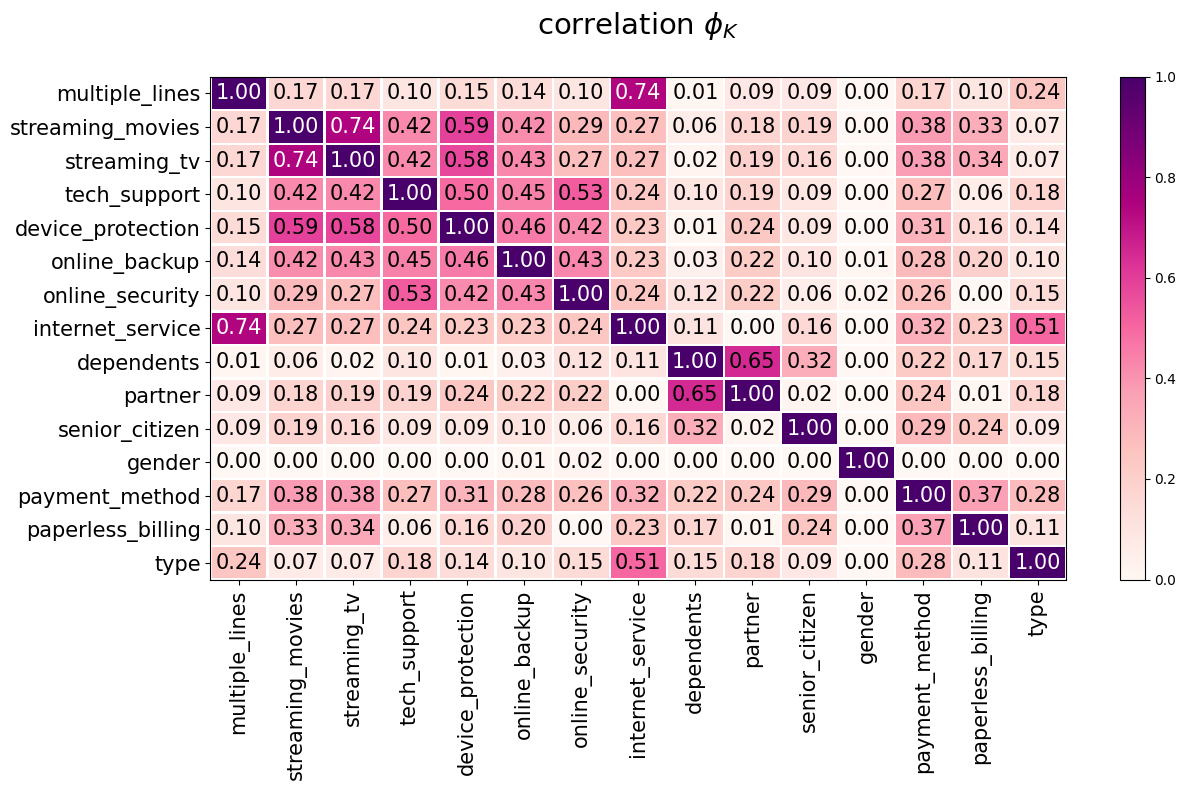

In [19]:
phik_data = full_data[cat]
phik_overview = phik_data.phik_matrix()

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="RdPu", 
                        title=r"correlation $\phi_K$" + "\n", 
                        fontsize_factor=1.5, 
                        figsize=(13, 8))

У признака multiple_lines есть корреляция с признаком internet_service, но в целом она не так ярко выражена, поэтому можно принебречь.

In [20]:
full_data.pivot_table(index=["streaming_tv", "streaming_movies"], values="monthly_charges", aggfunc="count")

monthly_charges
streaming_tv streaming_movies                 
No           No                           3544
             Yes                           792
Yes          No                            767
             Yes                          1940

In [21]:
full_data.pivot_table(index=["partner", "dependents"], values="monthly_charges", aggfunc="count")

monthly_charges
partner dependents                 
No      No                     3280
        Yes                     361
Yes     No                     1653
        Yes                    1749

У нас есть столбец с общими затратами клиента на услуги - total_charges, он по какой-то причине тоже категориальный, но само собой - это количественный признак, посмотрим в чем дело.

In [22]:
np.sort(full_data["total_charges"].unique())

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

В столбце есть пропуски в виде пробела, заполним их после детального изучения данных.

**Вывод:** Были рассмотрены четыре датасета, объединены в один, по индивидуальному номеру клиента, в результате чего образовались пропуски, потому что не все клиенты пользуются всеми услугами оператора, заполнили пропуски как отсутствие подключенной услуги. Обнаружены аномалии в столбце total_charges, решим, как с ними поступить после более детального изучения данных. Посмотрели на корреляции категориальных признаков между собой, высокой корреляции не нашли.

## Примерный план решения задачи

1. Исследование данных. Изучить взаимосвязь признаков с целевым признаком и между собой. Посмотреть особенности в данных, которые могут быть полезны для заказчика;
2. Обработка данных. Заполнить пропущенные значения и обработать аномалии в столбцах, изменить типы данных;
3. Подготовка признаков. Добавление новых признаков, если среди существующих признаков имеются неинформативные или вредные для модели, удалим их. Разделение данных на тренировочный и тестовый набор, кодирование (возможно масштабирование);
4. Обучение моделей. Подбор гиперпараметров для разных моделей. Сравнение на кросс-валидации;
5. Тестирование лучшей модели, сравнение с наивной моделью. Оформление отчета о работе.

### Цель проекта

Заказчик хочет научиться предсказывать уйдет ли клиент, чтобы удержать его с помощью специальных условий. Наша задача построить предсказательную модель для заказчика.

## Предобработка данных

Начнем с временных признаков из датасета о контрактах. Если не заполнена дата окончания (указано No), значит клиент еще с нами. Можем вычислить сколько времени клиент с нами, а сами временные признаки мы удалим, так как они не нужны для обучения моделей в нашем случае.

In [23]:
print("Самый ранний договор оформлен:", np.sort(full_data["begin_date"].unique())[0])
print("Самый поздний договор оформлен:", np.sort(full_data["begin_date"].unique())[-1])

Самый ранний договор оформлен: 2013-10-01
Самый поздний договор оформлен: 2020-02-01


In [24]:
full_data["begin_date"] = pd.to_datetime(full_data["begin_date"])
full_data["begin_date_year"] = full_data["begin_date"].dt.year

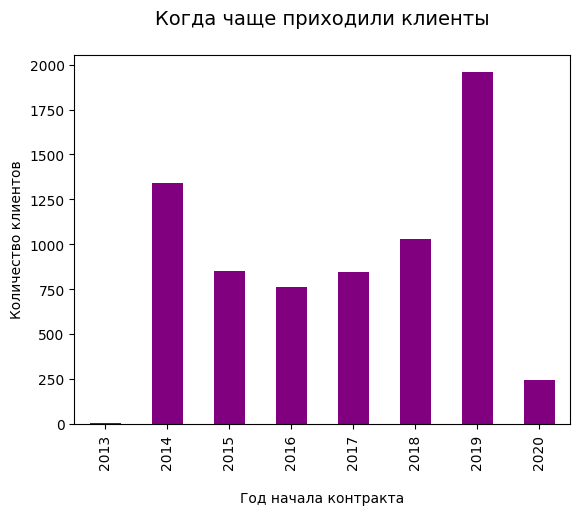

In [25]:
full_data.groupby("begin_date_year")["begin_date_year"].count().plot(y="begin_date_year",kind="bar", color="purple")
plt.xlabel("\n" + "Год начала контракта")
plt.ylabel("Количество клиентов")
plt.title("Когда чаще приходили клиенты" + "\n", fontsize=14);

In [26]:
print("Клиенты пришли в 2013 году в количестве:", len(full_data.loc[full_data["begin_date_year"] == 2013]))

Клиенты пришли в 2013 году в количестве: 8


In [27]:
full_data["begin_date"].loc[full_data["begin_date_year"] == 2013]

customerID
2834-JRTUA   2013-11-01
7317-GGVPB   2013-11-01
0917-EZOLA   2013-10-01
8580-QVLOC   2013-10-01
2889-FPWRM   2013-10-01
3512-IZIKN   2013-12-01
1555-DJEQW   2013-12-01
2530-ENDWQ   2013-12-01
Name: begin_date, dtype: datetime64[ns]

In [28]:
np.sort(full_data["end_date"].unique())

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

Данные выгружены 2020-02-01, как нам известно, думаю можно заполнить "No" этой датой, извлечь отсюда целевой признак и создать признак сколько времени клиент с нами. Необходимо проверить, что дата начала договора всегда раньше окончания (увидим если в созданном признаке будут отрицательные значения).

In [29]:
full_data.loc[(full_data["end_date"] == "No"), "end_date"] = "2020-02-01"

full_data["end_date"] = pd.to_datetime(full_data["end_date"])
full_data["end_date_year"] = full_data["end_date"].dt.year

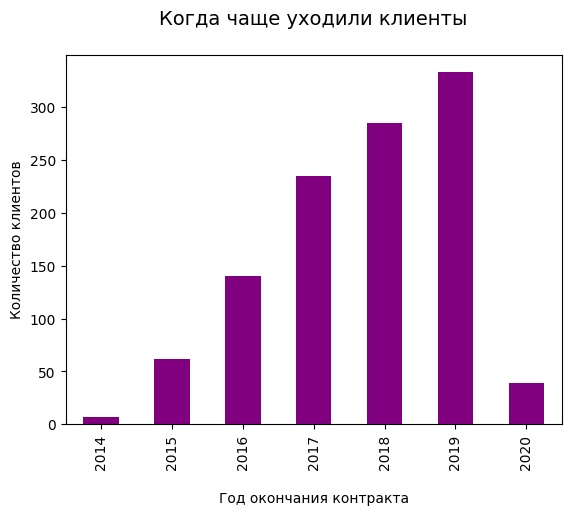

In [30]:
(
    full_data
    .loc[full_data["end_date"] < "2020-02-01"]
    .groupby("end_date_year")["end_date_year"].count()
    .plot(y="end_date_year",kind="bar", color="purple")
)
plt.xlabel("\n" + "Год окончания контракта")
plt.ylabel("Количество клиентов")
plt.title("Когда чаще уходили клиенты" + "\n", fontsize=14);

In [31]:
full_data["period_contract"] = (full_data["end_date"] - full_data["begin_date"]).dt.days
full_data.loc[(full_data["end_date"] == "2020-02-01"), "off_contract"] = 0
full_data.loc[(full_data["end_date"] != "2020-02-01"), "off_contract"] = 1

In [32]:
print("Минимальный период действия контракта, дней:", full_data["period_contract"].min())

Минимальный период действия контракта, дней: 0


In [33]:
print("Контрактов, которые действовали 0 дней:", len(full_data.loc[full_data["period_contract"] == 0]))

Контрактов, которые действовали 0 дней: 11


In [34]:
full_data["begin_date"].loc[full_data["period_contract"] == 0]

customerID
4472-LVYGI   2020-02-01
3115-CZMZD   2020-02-01
5709-LVOEQ   2020-02-01
4367-NUYAO   2020-02-01
1371-DWPAZ   2020-02-01
7644-OMVMY   2020-02-01
3213-VVOLG   2020-02-01
2520-SGTTA   2020-02-01
2923-ARZLG   2020-02-01
4075-WKNIU   2020-02-01
2775-SEFEE   2020-02-01
Name: begin_date, dtype: datetime64[ns]

Все в порядке, это совсем новые контракты, которые успели оформить в день выгрузки. Проверим уходили ли клиенты, которые пришли месяц назад.

In [35]:
full_data["end_date"].loc[(full_data["begin_date_year"] == 2020)].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

Не уходили.

In [36]:
full_data["off_contract"] = full_data["off_contract"].astype(int)

full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

Временные признаки и вспомогательные столбцы удалим после анализа данных.

Перейдем к самому главному, траты клиентов на услуги, ежемесячные и общие.

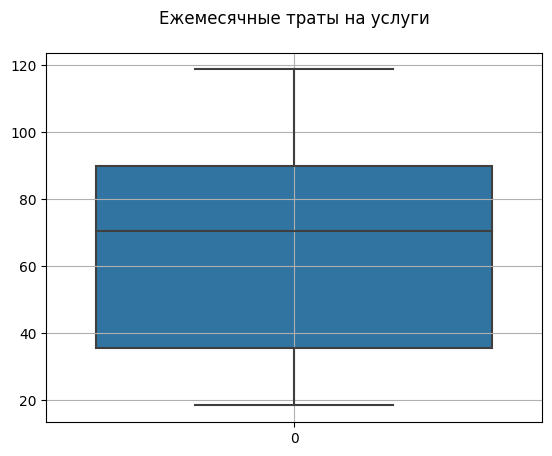

In [37]:
sns.boxplot(data=full_data["monthly_charges"])
plt.grid(True)
plt.title("Ежемесячные траты на услуги" + "\n");

Хороший столбец, нет выбросов, пропусков, аномалий. В общих затратах мы обнаружили аномалии, есть значение пробел, посмотрим на эти строки.

In [38]:
check_total_charges = full_data.loc[full_data["total_charges"] == " "]
check_total_charges

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_date_year,end_date_year,period_contract,off_contract
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,No,Yes,...,No,Yes,Yes,Yes,No,No phone,2020,2020,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,No,No,...,No,No,No,No,No,No,2020,2020,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,No,Yes,...,Yes,Yes,No,Yes,Yes,No,2020,2020,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,No,Yes,...,No,No,No,No,No,Yes,2020,2020,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,No,Yes,...,Yes,Yes,Yes,Yes,No,No phone,2020,2020,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,No,Yes,...,No,No,No,No,No,Yes,2020,2020,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0


Общие затраты не заполнены по 11 контрактам, это контракты, которые успели оформить в день выгрузки, можно заполнить пропуски ежемесячным платежом, предполагаем, что клиент платит вперед и платеж не успел отобразиться в базе данных.

In [39]:
full_data.loc[full_data["total_charges"] == " ", "total_charges"] = full_data["monthly_charges"]
full_data.loc[check_total_charges.index]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_date_year,end_date_year,period_contract,off_contract
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,Yes,...,No,Yes,Yes,Yes,No,No phone,2020,2020,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,Male,No,No,...,No,No,No,No,No,No,2020,2020,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,Female,No,Yes,...,Yes,Yes,No,Yes,Yes,No,2020,2020,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,Male,No,Yes,...,No,No,No,No,No,Yes,2020,2020,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,Female,No,Yes,...,Yes,Yes,Yes,Yes,No,No phone,2020,2020,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,Male,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,Male,No,Yes,...,No,No,No,No,No,Yes,2020,2020,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.0,Female,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.7,Male,No,Yes,...,No,No,No,No,No,No,2020,2020,0,0


In [40]:
full_data["total_charges"] = full_data["total_charges"].astype(float)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

In [41]:
full_data[:2]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_date_year,end_date_year,period_contract,off_contract
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,...,Yes,No,No,No,No,No phone,2020,2020,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,No,No,...,No,Yes,No,No,No,No,2017,2020,1036,0


Все выглядит хорошо. Можно сразу дропнуть временные признаки, мы не будем использовать их для анализа, а вот года, извлеченные из них используем, но модели не отдадим.

In [42]:
full_data = full_data.drop(columns = ["begin_date", "end_date"], axis = 1)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

## EDA

Посмотрим снова корреляции, но уже всех признаков и целевого (off_contract).

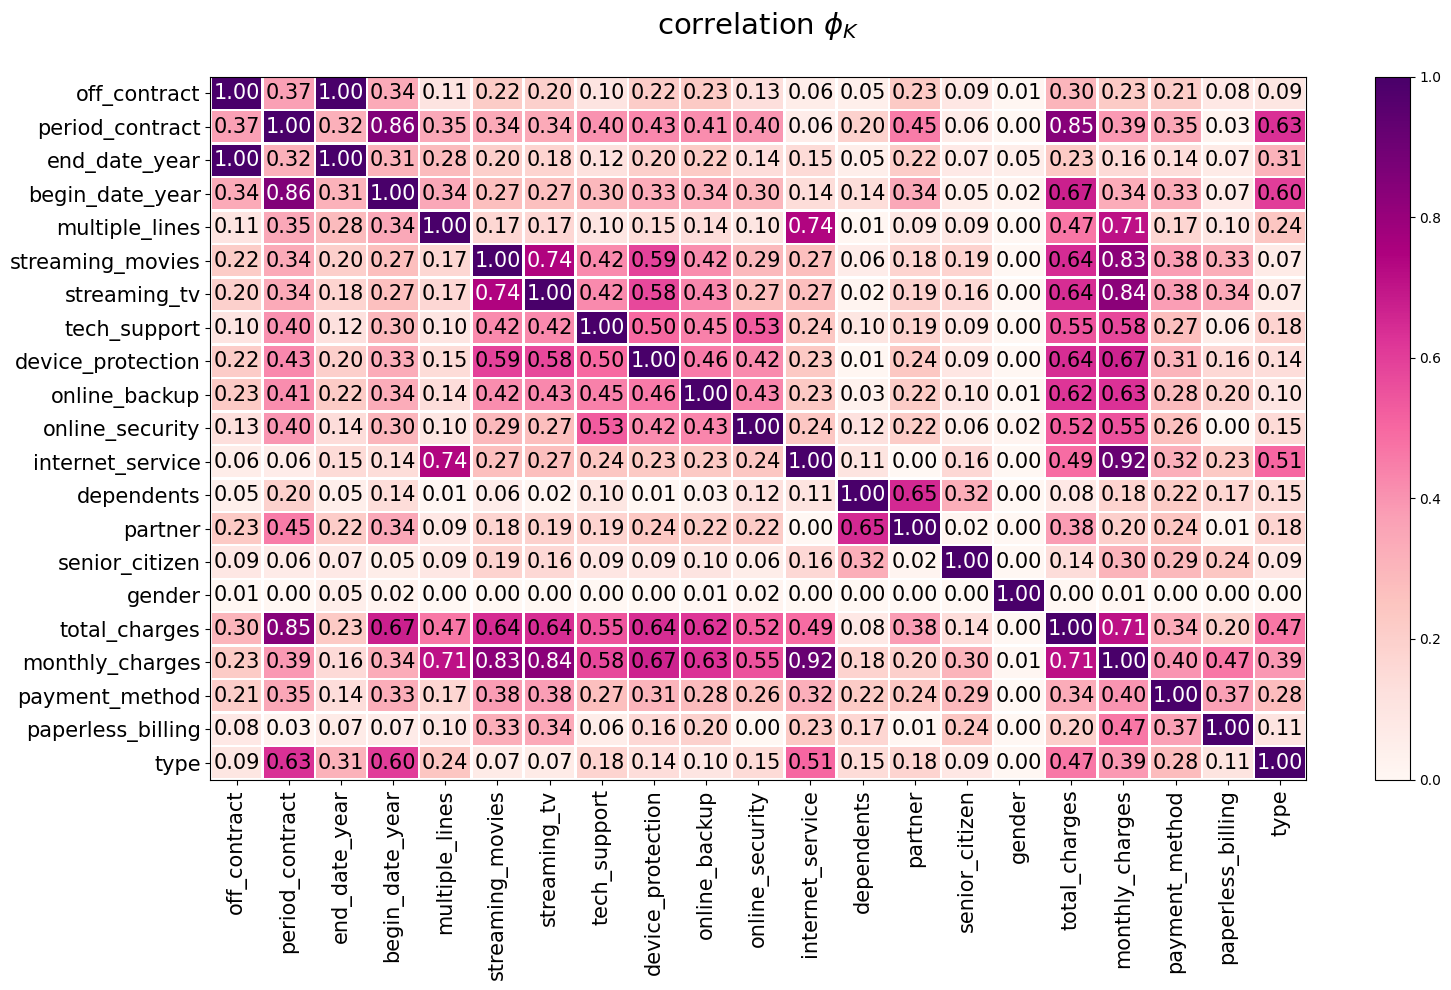

In [43]:
interval_columns = ["monthly_charges", "total_charges", "begin_date_year", 
                    "end_date_year", "period_contract", "off_contract"]

phik_overview = full_data.phik_matrix(interval_cols = interval_columns)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="RdPu", 
                        title=r"correlation $\phi_K$" + "\n", 
                        fontsize_factor=1.5, 
                        figsize=(16, 10))

Можно предположить сразу: хорошую предсказательную способность будет иметь, созданный нами признак с периодом сотрудничества и общие затраты, что по сути одно и тоже (чем дольше клиент является клиентом, тем больше он принес денег), возможно нужно повнимательнее посмотреть на новых клиентов, приступим.

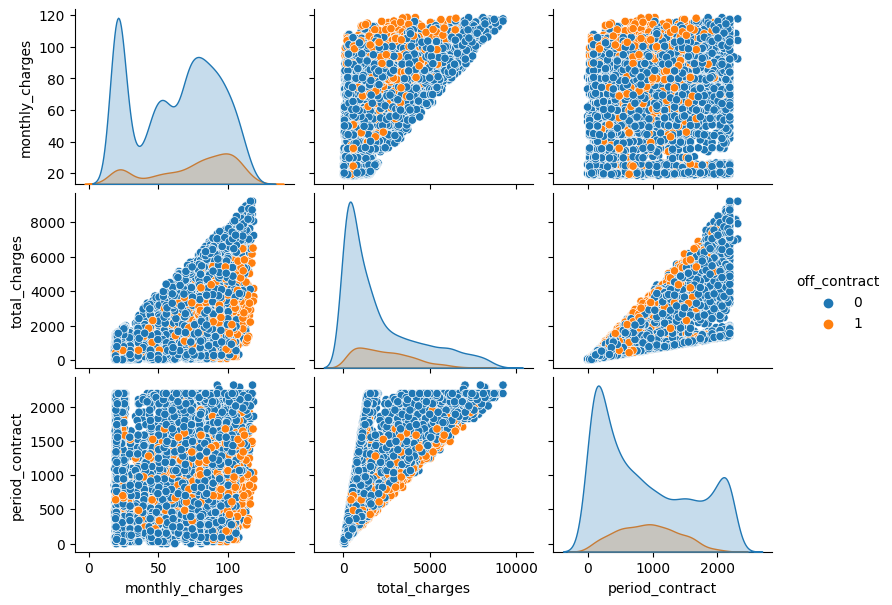

In [44]:
sns.pairplot(full_data[["monthly_charges", "total_charges", "period_contract", "off_contract"]], hue="off_contract")
plt.gcf().set_size_inches(9, 6);

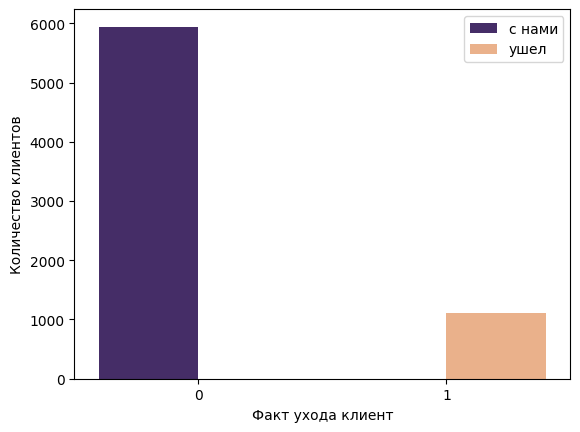

In [45]:
sns.countplot(data=full_data, x="off_contract", hue="off_contract", palette=["#432371","#FAAE7B"])
plt.xlabel("Факт ухода клиент")
plt.ylabel("Количество клиентов")
plt.legend(labels = ["с нами", "ушел"]);

В целевом признаке наблюдается дисбаланс, примерно 1:6. Посмотрим на другие признаки. Начнем с периода действия контракта.

In [46]:
# датасеты с ушедшими и оставшимися клиентами
data_off = full_data.loc[full_data["off_contract"] == 1]
data_on = full_data.loc[full_data["off_contract"] == 0]

In [47]:
full_data.period_contract.value_counts(bins=20)

(115.7, 231.4]      815
(-2.315, 115.7]     728
(231.4, 347.1]      532
(2082.6, 2198.3]    520
(347.1, 462.8]      484
(694.2, 809.9]      399
(578.5, 694.2]      368
(809.9, 925.6]      351
(462.8, 578.5]      346
(925.6, 1041.3]     340
(1041.3, 1157.0]    309
(1504.1, 1619.8]    270
(1388.4, 1504.1]    267
(1272.7, 1388.4]    257
(1966.9, 2082.6]    249
(1157.0, 1272.7]    218
(1851.2, 1966.9]    217
(1735.5, 1851.2]    184
(1619.8, 1735.5]    183
(2198.3, 2314.0]      6
Name: period_contract, dtype: int64

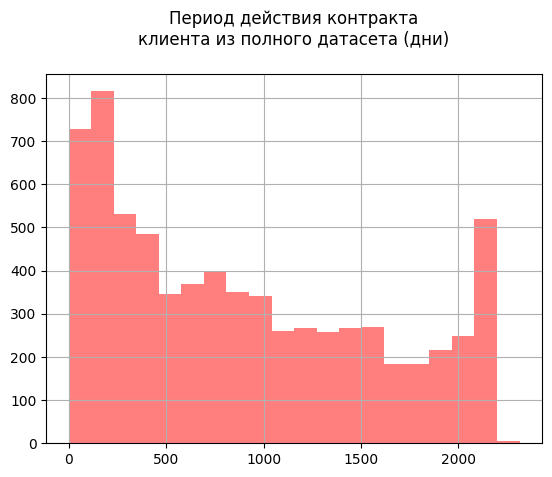

In [48]:
full_data.period_contract.hist(bins=20, alpha=0.5, color="red")
plt.title("Период действия контракта" + "\n" + "клиента из полного датасета (дни)" + "\n");

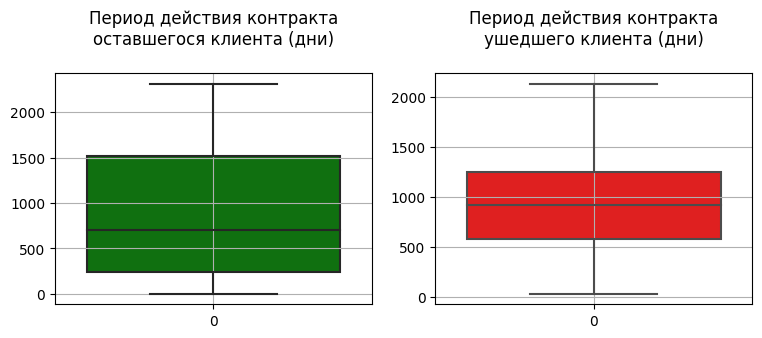

In [49]:
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(9)

plt.subplot(1, 2, 1)
sns.boxplot(data=data_on["period_contract"], color="green")
plt.grid(True)
plt.title("Период действия контракта" + "\n" + "оставшегося клиента (дни)" + "\n")

plt.subplot(1, 2, 2)
sns.boxplot(data=data_off["period_contract"], color="red")
plt.grid(True)
plt.title("Период действия контракта" + "\n" + "ушедшего клиента (дни)" + "\n");

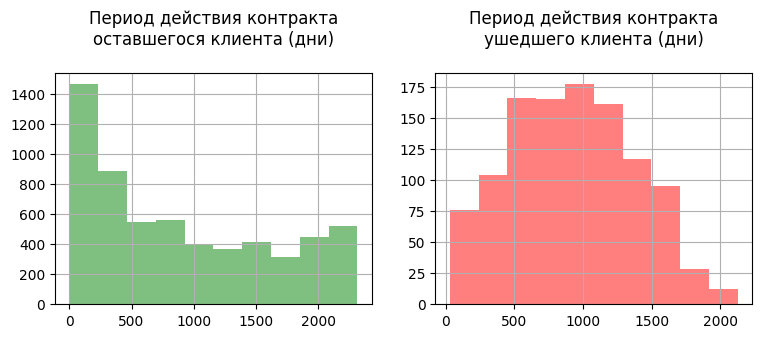

In [50]:
plt.subplot(1, 2, 1)
data_on["period_contract"].hist(figsize=(9, 3), alpha=0.5, color="green")
plt.title("Период действия контракта" + "\n" + "оставшегося клиента (дни)" + "\n")

plt.subplot(1, 2, 2)
data_off["period_contract"].hist(figsize=(9, 3), alpha=0.5, color="red")
plt.title("Период действия контракта" + "\n" + "ушедшего клиента (дни)" + "\n");

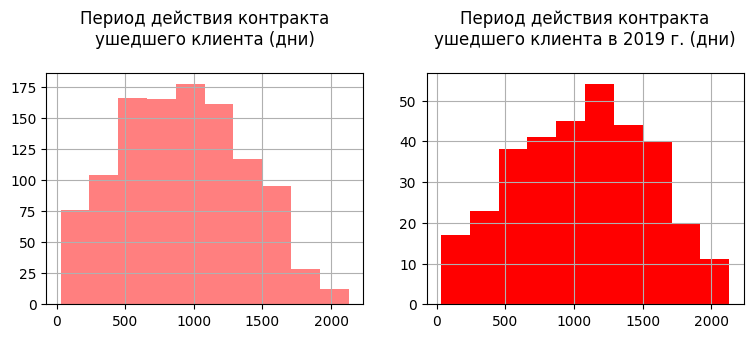

In [51]:
plt.subplot(1, 2, 1)
data_off["period_contract"].hist(figsize=(9, 3), alpha=0.5, color="red")
plt.title("Период действия контракта" + "\n" + "ушедшего клиента (дни)" + "\n")

plt.subplot(1, 2, 2)
data_off.loc[data_off["end_date_year"] == 2019]["period_contract"].hist(figsize=(9, 3), color="red")
plt.title("Период действия контракта" + "\n" + "ушедшего клиента в 2019 г. (дни)" + "\n");

Можно сделать вывод, что чаще уходят клиенты с длительным периодом действия договора (это видно и за весь период в данных и в год, когда ушло больше всего клиентов), примерно через полтора года и до 4 с половиной лет, более новые или старые клиенты уходят реже. Возможно у очень старых клиентов особые условия, а новым предоставляются скидки, и вот когда, этот период кончается, клиенты ищут нового оператора.

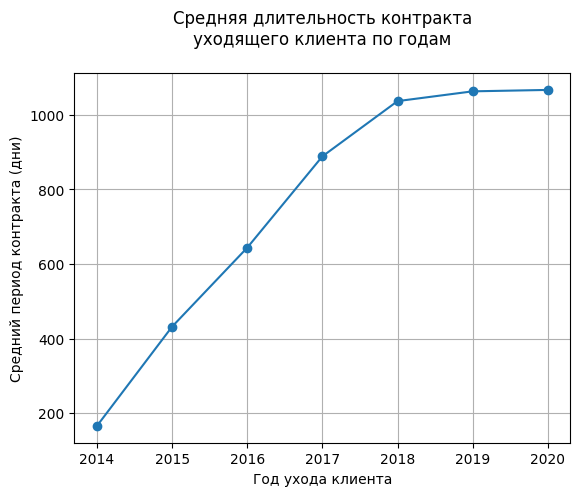

In [52]:
(
data_off
    .pivot_table(index="end_date_year", values="period_contract")
    .plot(style="o-", grid=True, legend=False)
)
plt.xlabel("Год ухода клиента")
plt.ylabel("Средний период контракта (дни)")
plt.title("Средняя длительность контракта" + "\n" + "уходящего клиента по годам" + "\n");

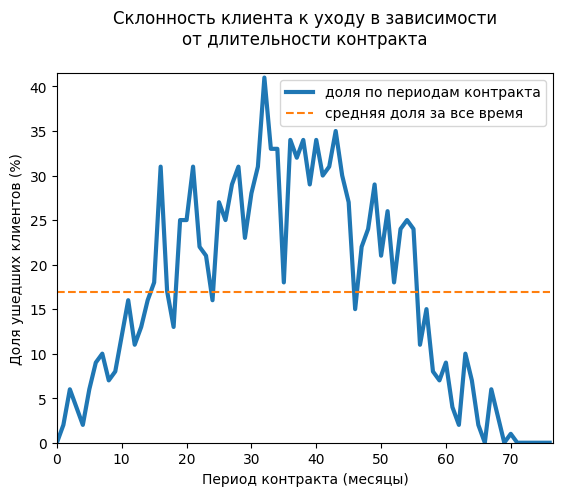

In [53]:
avg_tendency = full_data.loc[:, "end_date_year":"off_contract"]
avg_tendency["period_contract_month"] = round(avg_tendency["period_contract"] / 30.4167)
avg_tendency_pivot = avg_tendency.pivot_table(index="period_contract_month", values=["off_contract"])
avg_tendency_pivot.columns = ["off_share"]
avg_tendency_pivot["off_share"] = round(avg_tendency_pivot["off_share"] * 100)
avg_tendency_pivot["mean"] = avg_tendency_pivot["off_share"].mean()

avg_tendency_pivot["off_share"].plot(grid=True, 
                                     linewidth=3, 
                                     legend=True, 
                                     ylabel="Доля ушедших клиентов (%)")
avg_tendency_pivot["mean"].plot(linestyle="--", xlabel="Период контракта (месяцы)")

plt.legend(labels = ["доля по периодам контракта", "средняя доля за все время"])
plt.xlim([0.0, avg_tendency_pivot.index.max()+0.5])
plt.ylim([0.0, avg_tendency_pivot["off_share"].max()+0.5])
plt.title("Склонность клиента к уходу в зависимости" + "\n" + "от длительности контракта" + "\n");

Посмотрим типы договоров по годам начала контракта.

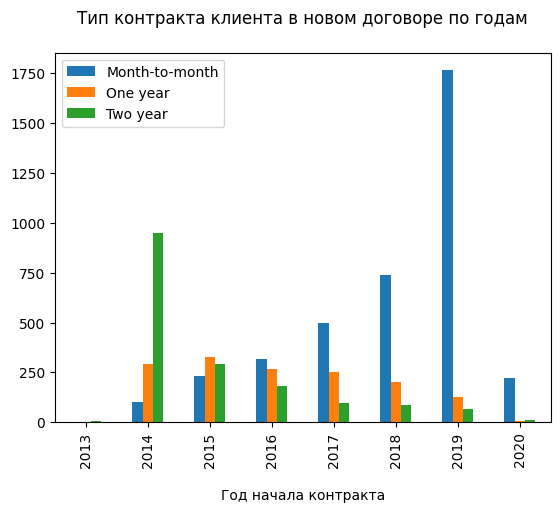

In [54]:
df_type_for_plot = (
    full_data[["begin_date_year", "type", "monthly_charges"]]
    .pivot_table(index="begin_date_year", columns="type", aggfunc="count")
)
df_type_for_plot.columns = ["Month-to-month", "One year", "Two year"]
df_type_for_plot["begin_date_year"] = df_type_for_plot.index

df_type_for_plot.plot(x="begin_date_year", kind="bar").set_xlabel( "\n" + "Год начала контракта")
plt.title("Тип контракта клиента в новом договоре по годам" + "\n");

Мы можем видеть снижение количества длительных контрактов и увеличение контрактов, оплачиваемых помесячно среди всех клиентов компании. Посмотрим на связь платежей и наличия доп.услуг.

In [55]:
additional_services = ["multiple_lines", "streaming_tv", "streaming_movies", "tech_support", 
                       "device_protection", "online_security", "online_backup"]

for i in additional_services:
    print("\n", "Доп.услуга:", i)
    print("Средний ежемесячный платеж клиентов с услугой:", 
          round(full_data.loc[full_data[i] == "Yes"]["monthly_charges"].mean(), 2))
    print("Средний ежемесячный платеж клиентов без услуги:", 
          round(full_data.loc[full_data[i] == "No"]["monthly_charges"].mean(), 2))
    print("Средние общие затраты клиентов с услугой:", 
          round(full_data.loc[full_data[i] == "Yes"]["total_charges"].mean(), 2))
    print("Средние общие затраты клиентов без услуги:", 
          round(full_data.loc[full_data[i] == "No"]["total_charges"].mean(), 2))


 Доп.услуга: multiple_lines
Средний ежемесячный платеж клиентов с услугой: 82.04
Средний ежемесячный платеж клиентов без услуги: 54.2
Средние общие затраты клиентов с услугой: 3199.7
Средние общие затраты клиентов без услуги: 1312.58

 Доп.услуга: streaming_tv
Средний ежемесячный платеж клиентов с услугой: 88.74
Средний ежемесячный платеж клиентов без услуги: 49.79
Средние общие затраты клиентов с услугой: 3446.07
Средние общие затраты клиентов без услуги: 1284.61

 Доп.услуга: streaming_movies
Средний ежемесячный платеж клиентов с услугой: 88.48
Средний ежемесячный платеж клиентов без услуги: 49.73
Средние общие затраты клиентов с услугой: 3428.46
Средние общие затраты клиентов без услуги: 1283.24

 Доп.услуга: tech_support
Средний ежемесячный платеж клиентов с услугой: 80.68
Средний ежемесячный платеж клиентов без услуги: 58.25
Средние общие затраты клиентов с услугой: 3503.73
Средние общие затраты клиентов без услуги: 1547.7

 Доп.услуга: device_protection
Средний ежемесячный плате

Клиенты с доп.услугами платят больше, это, конечно и так было очевидно.

In [56]:
print("Клиенты, подключенные к интернету через телефонную линию в среднем, в месяц платят:", 
      round(full_data.loc[full_data["internet_service"] == "DSL"]["monthly_charges"].mean(),2))
print("Клиенты, подключенные к интернету через оптоволоконный кабель в среднем, в месяц платят:", 
      round(full_data.loc[full_data["internet_service"] == "Fiber optic"]["monthly_charges"].mean(),2))
print("Клиенты, не подключенные к интернету в среднем, в месяц платят:", 
      round(full_data.loc[full_data["internet_service"] == "No"]["monthly_charges"].mean(),2))

Клиенты, подключенные к интернету через телефонную линию в среднем, в месяц платят: 58.1
Клиенты, подключенные к интернету через оптоволоконный кабель в среднем, в месяц платят: 91.5
Клиенты, не подключенные к интернету в среднем, в месяц платят: 21.08


Оптоволоконный кабель значительно дороже. Посмотрим какой тип интернета подключали клиенты по годам.

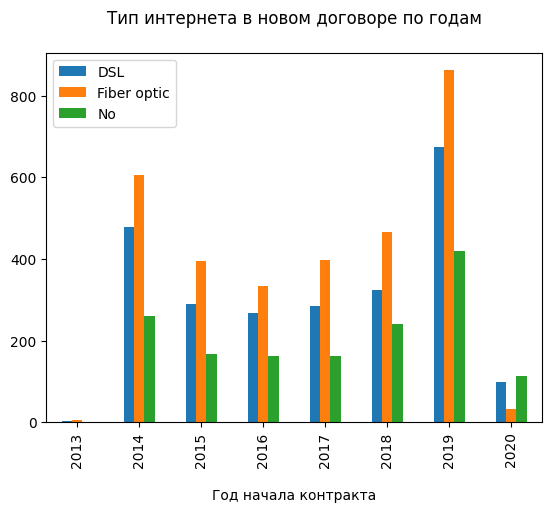

In [57]:
df_internet_service_for_plot = (
    full_data[["begin_date_year", "internet_service", "monthly_charges"]]
    .pivot_table(index="begin_date_year", columns="internet_service", aggfunc="count")
)
df_internet_service_for_plot.columns = ["DSL", "Fiber optic", "No"]
df_internet_service_for_plot["begin_date_year"] = df_internet_service_for_plot.index

df_internet_service_for_plot.plot(x="begin_date_year", kind="bar").set_xlabel( "\n" + "Год начала контракта")
plt.title("Тип интернета в новом договоре по годам" + "\n");

Похоже на то, что клиенты подключают разные типы интернета или не подключают интернет примерно одинаково за весь период в данных. Посмотрим на выбросы в столбце с общими затратами.

In [58]:
full_data["total_charges"].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

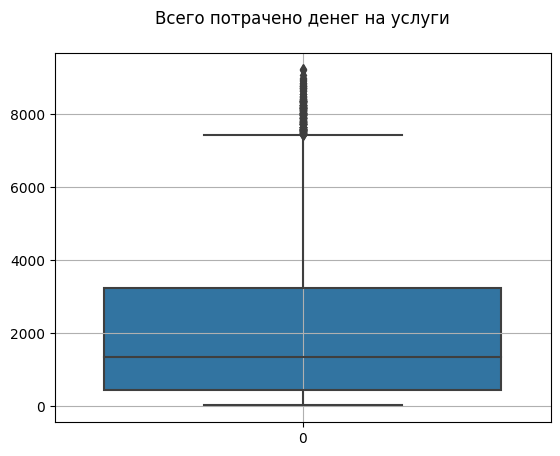

In [59]:
sns.boxplot(data=full_data["total_charges"])
plt.grid(True)
plt.title("Всего потрачено денег на услуги" + "\n");

In [60]:
Q1 =  full_data["total_charges"].quantile(0.25)
Q3 = full_data["total_charges"].quantile(0.75)
IQR = Q3 - Q1
over_price = round(Q3 + 1.5 * IQR, 2)
print("Выбросы выше стоимости", over_price)

Выбросы выше стоимости 7436.6


In [61]:
print("Объектов с выбросами", len(full_data.loc[full_data["total_charges"] > over_price]))

Объектов с выбросами 195


In [62]:
print("Ежемесячный платеж для клиентов с очень большой общей суммой затрат:")
print("min", full_data.loc[full_data["total_charges"] > over_price]["monthly_charges"].min())
print("median",full_data.loc[full_data["total_charges"] > over_price]["monthly_charges"].median())
print("max",full_data.loc[full_data["total_charges"] > over_price]["monthly_charges"].max())

Ежемесячный платеж для клиентов с очень большой общей суммой затрат:
min 94.25
median 110.5
max 118.6


У клиентов с выбивающимися по общей сумме затратами и ежемесячный платеж высокий, может это юр.лица, ничего не делаем, оставляем строки.

### Портрет уходящего клиента

Признак type
Month-to-month доля ушедших: 0.11
One year доля ушедших: 0.21
Two year доля ушедших: 0.22


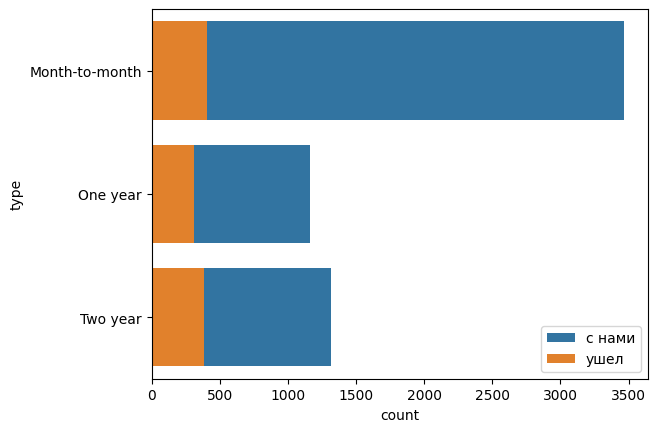

Признак paperless_billing
Yes доля ушедших: 0.17
No доля ушедших: 0.13


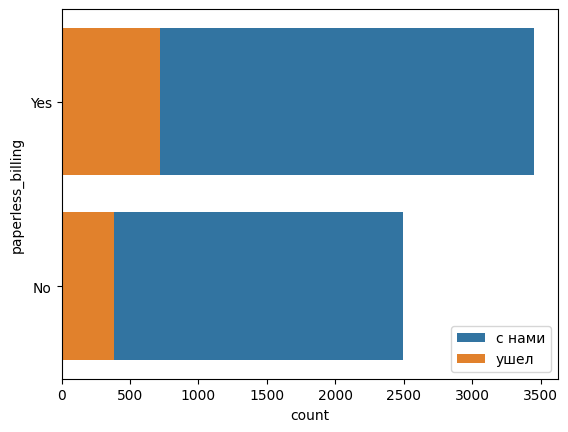

Признак payment_method
Electronic check доля ушедших: 0.15
Mailed check доля ушедших: 0.07
Bank transfer (automatic) доля ушедших: 0.21
Credit card (automatic) доля ушедших: 0.21


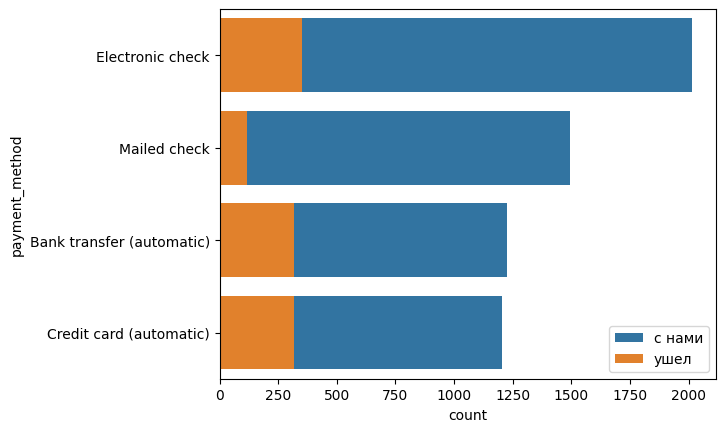

Признак gender
Female доля ушедших: 0.15
Male доля ушедших: 0.16


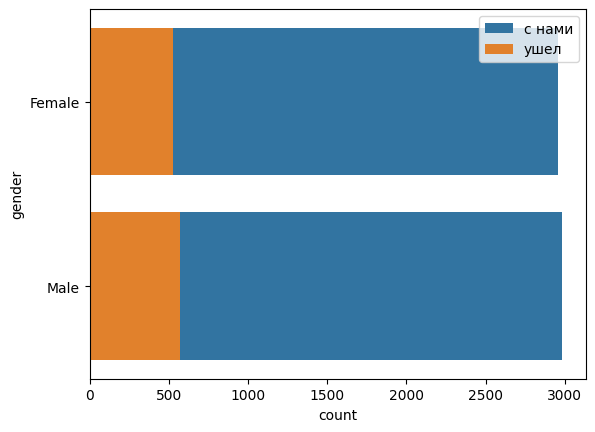

Признак senior_citizen
No доля ушедших: 0.15
Yes доля ушедших: 0.2


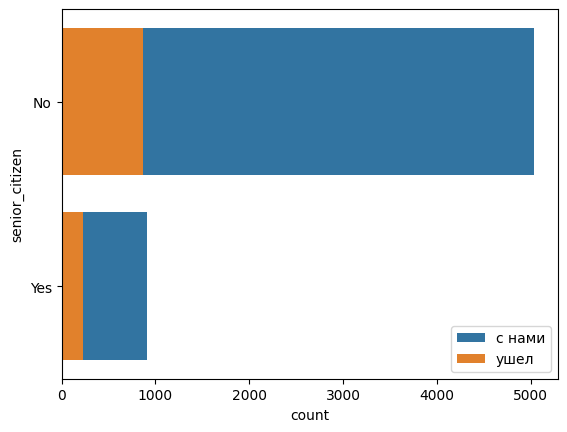

Признак partner
Yes доля ушедших: 0.21
No доля ушедших: 0.1


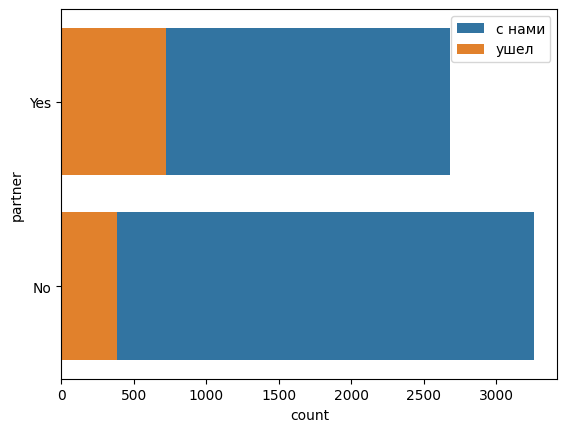

Признак dependents
No доля ушедших: 0.15
Yes доля ушедших: 0.17


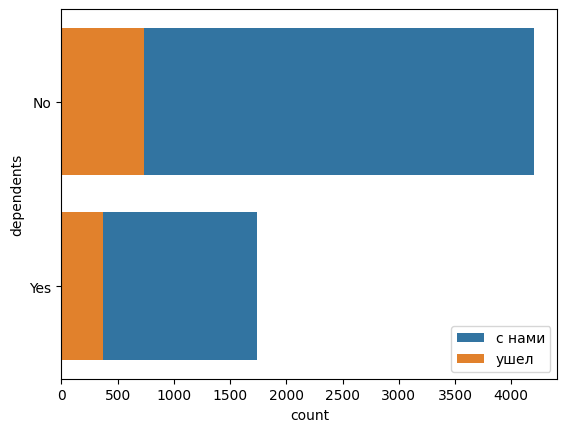

Признак internet_service
DSL доля ушедших: 0.14
Fiber optic доля ушедших: 0.19
No доля ушедших: 0.1


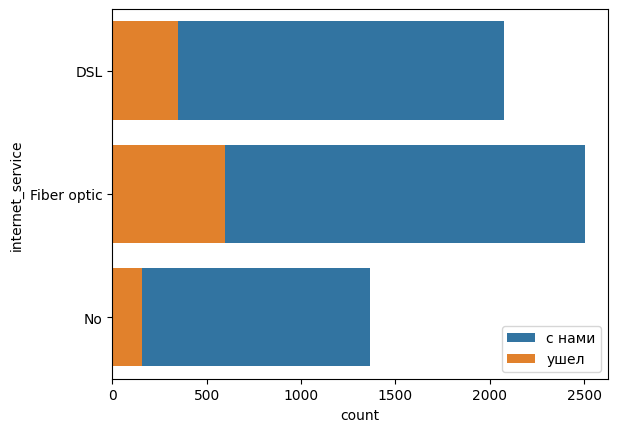

Признак online_security
No доля ушедших: 0.14
Yes доля ушедших: 0.21


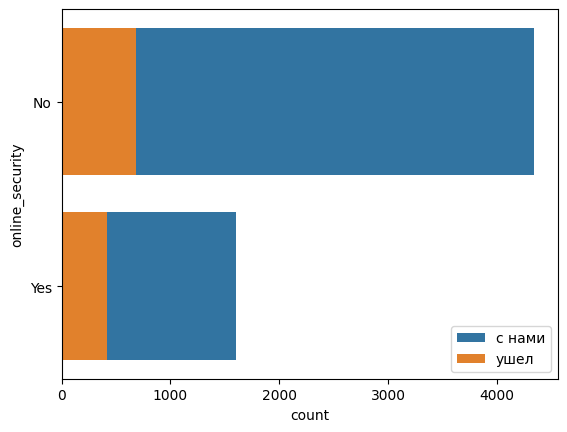

Признак online_backup
Yes доля ушедших: 0.23
No доля ушедших: 0.12


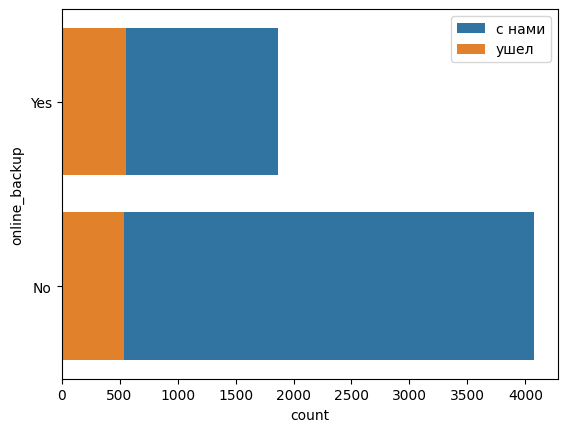

Признак device_protection
No доля ушедших: 0.12
Yes доля ушедших: 0.23


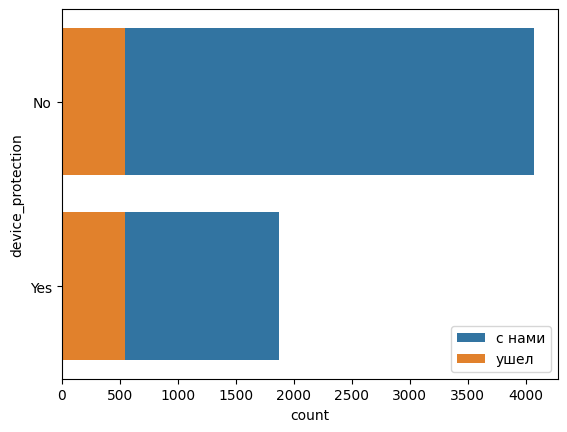

Признак tech_support
No доля ушедших: 0.14
Yes доля ушедших: 0.19


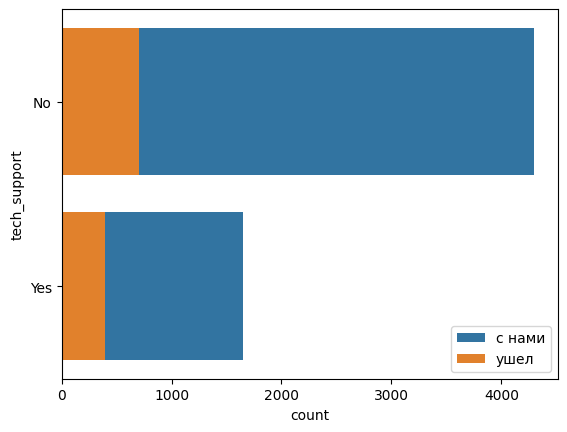

Признак streaming_tv
No доля ушедших: 0.12
Yes доля ушедших: 0.22


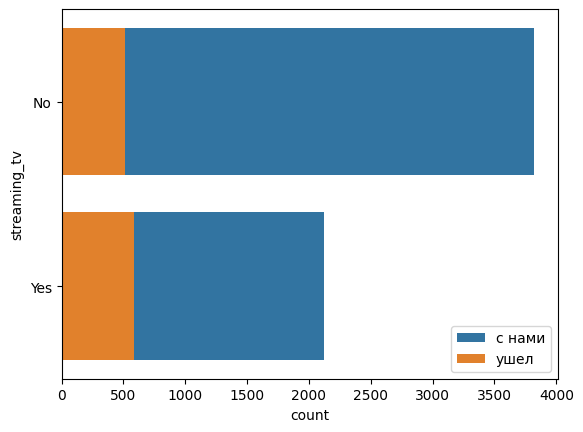

Признак streaming_movies
No доля ушедших: 0.11
Yes доля ушедших: 0.22


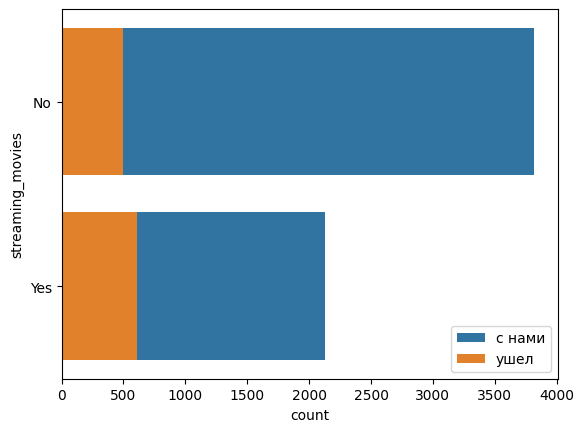

Признак multiple_lines
No phone доля ушедших: 0.15
No доля ушедших: 0.09
Yes доля ушедших: 0.23


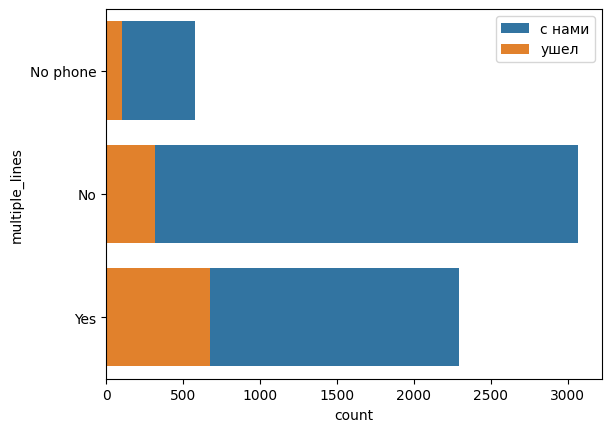

In [63]:
col_for_target_survey = []

for col in full_data.columns:
    if col not in interval_columns:
        col_for_target_survey.append(col)

def countplot_show (colum):
    print("Признак", colum)
    for uni in full_data[colum].unique():
        print(uni, "доля ушедших:", round((data_off.loc[data_off[colum] == uni].shape[0] / 
                                         full_data.loc[full_data[colum] == uni].shape[0]), 2))
    sns.countplot(y=full_data[colum], hue=full_data["off_contract"], dodge=False)
    plt.legend(labels = ["с нами", "ушел"])
    plt.show()
        
for col_for_survey in col_for_target_survey:
    countplot_show (col_for_survey)

In [64]:
def box_charges (df_on, df_off, charge, charge_title):
    
    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_on[charge], color="green")
    plt.grid(True)
    plt.title(charge_title + "\n" + "траты на услуги" + "\n" + "оставшихся клиентов" + "\n")

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_off[charge], color="red")
    plt.grid(True)
    plt.title(charge_title + "\n" + "траты на услуги" + "\n" + "ушедших клиентов" + "\n");

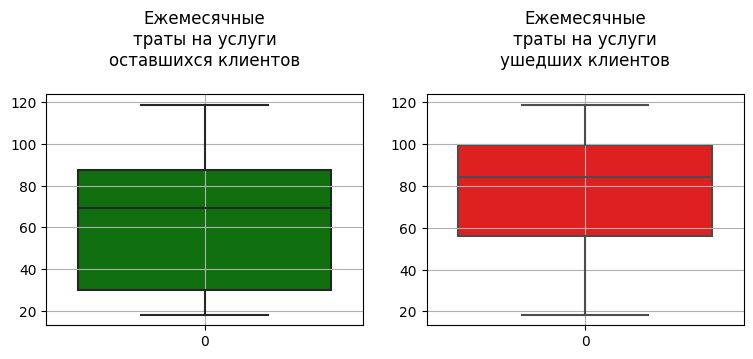

In [65]:
box_charges (data_on, data_off, "monthly_charges", "Ежемесячные")

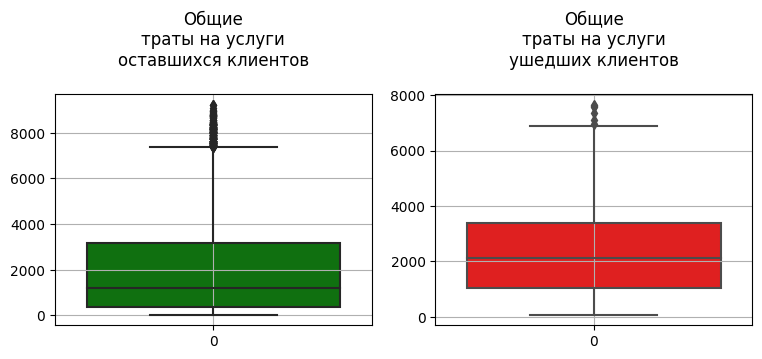

In [66]:
box_charges (data_on, data_off, "total_charges", "Общие")

**Вывод:** С 2016 года количество новых клиентов растет, а в 2019 году пришло значительно больше клиентов, чем в предыдущие года. Уходят каждый год тоже больше клиентов, а за весь период данных ушло 18,5% клиентов. Можно сделать вывод, что чаще уходят клиенты с длительным периодом действия договора, примерно через полтора года и до 4 с половиной лет, более новые или старые клиенты уходят реже. с 2016 года мы можем видеть снижение количества длительных контрактов и значительное увеличение контрактов, оплачиваемых помесячно среди всех клиентов компании. Мужчины и женщины примерно одинаково представлены в данных. Среди клиентов компании больше людей, не достигших пенсионного возраста, без супругов или иждивенцев. Клиенты предпочитают интернет, подключенный по оптоволоконному кабелю, и он значительно дороже, в основном не пользуются допами, а те, кто их использует - платят больше. Больше выбирают способ оплаты - Electronic check, а также выставление счёта на электронную почту. 

*Портрет уходящего клиента:*   
1. тип договора - длительный
2. траты клиента - высокие, в том числе подключены доп.услуги (online security, online backup, device protection, tech support, streaming tv, streaming movies, multiple lines)
3. способ оплаты - automatic (bank transfer или credit card)
4. пенсионер, или есть супруг, или иждивенец

## Обучение моделей

У нас много категориальных признаков, есть столбцы с взаимной корреляцией, обучим бустинговые модели и случайный лес. Для случайного леса закодируем данные с помощью OneHotEncoder. Бустинговые модели умеют работать с категориями самостоятельно. Для подбора гиперпараметров используем GridSearchCV и RandomizedSearchCV, оставлю в словаре только лучшие, ранее подобранные параметры. Во избежание утечки данных во время кросс-валидации используем Pipeline. Для борьбы с дисбалансом установим параметр class_weights = balanced, это важно для нашей вспомогательной метрики accuracy, заказчик, вероятнее всего будет обращать внимание на эту метрику, т.к. она более понятна.

### Feature selection

Мы создали признак - период действия контракта, как показал анализ данных, признак должен быть полезен. Теперь можно удалить вспомогательные признаки (год начала и конца договора), при обучении их нельзя использовать, потому что наш таргет был образован на основании этих данных. Избавимся от признака - пол клиента, он ни на что не влияет.

In [67]:
full_data = full_data.drop(["begin_date_year", "end_date_year", "gender"], axis=1)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   senior_citizen     7043 non-null   object 
 6   partner            7043 non-null   object 
 7   dependents         7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
 16  period_contrac

### Подготовка данных

In [68]:
train, test = train_test_split(full_data, test_size=TEST_SIZE, random_state=STATE, stratify=full_data["off_contract"])

print(test.shape[0] + train.shape[0] == full_data.shape[0])
print(round(train.shape[0]/full_data.shape[0], 2) == 1 - TEST_SIZE)
print(round(test.shape[0]/full_data.shape[0], 2) == TEST_SIZE)

X_train = train.drop("off_contract", axis=1)
y_train = train["off_contract"]

X_test = test.drop("off_contract", axis=1)
y_test = test["off_contract"]

print(round(train.off_contract.sum()/train.off_contract.shape[0], 2) == 
      round(test.off_contract.sum()/test.off_contract.shape[0], 2))

True
True
True
True


### CatBoost

In [69]:
cat.remove("gender")

In [70]:
%%time

pipe_cb = Pipeline([("model", CatBoostClassifier(cat_features=cat, random_state=STATE))])

parametrs_cb = {"model__logging_level": ["Silent"], 
                "model__learning_rate": [0.3], 
                "model__iterations": [1000], 
                "model__depth": [2], 
                "model__eval_metric": ["AUC"], 
                "model__auto_class_weights": ["Balanced"]}

model_cb = GridSearchCV(estimator=pipe_cb, 
                        param_grid=parametrs_cb, 
                        scoring=["roc_auc", "accuracy"], 
                        refit="roc_auc", 
                        n_jobs=-1)

start_cb = time.time()
model_cb.fit(X_train, y_train)
fit_time_cb = round(time.time() - start_cb, 3)

print("Время обучения модели:", fit_time_cb)

Время обучения модели: 69.325
CPU times: total: 23 s
Wall time: 1min 9s


In [71]:
print("Параметры лучшей модели:")
model_cb.best_params_

Параметры лучшей модели:


{'model__auto_class_weights': 'Balanced',
 'model__depth': 2,
 'model__eval_metric': 'AUC',
 'model__iterations': 1000,
 'model__learning_rate': 0.3,
 'model__logging_level': 'Silent'}

In [72]:
res_cb = pd.DataFrame(model_cb.cv_results_)
roc_auc_cb = round(res_cb["mean_test_roc_auc"].max(), 2)
accuracy_cb = round(res_cb.loc[res_cb["mean_test_roc_auc"] == res_cb["mean_test_roc_auc"].max()]
                    ["mean_test_accuracy"].max(), 2)
print("roc_auc:", roc_auc_cb)
print("accuracy:", accuracy_cb)

roc_auc: 0.93
accuracy: 0.89


### LightGBM

In [73]:
X_train_lgbm = X_train.copy()
X_train_lgbm[cat] = X_train_lgbm[cat].astype("category")
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 3488-PGMQJ to 1842-EZJMK
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5282 non-null   category
 1   paperless_billing  5282 non-null   category
 2   payment_method     5282 non-null   category
 3   monthly_charges    5282 non-null   float64 
 4   total_charges      5282 non-null   float64 
 5   senior_citizen     5282 non-null   category
 6   partner            5282 non-null   category
 7   dependents         5282 non-null   category
 8   internet_service   5282 non-null   category
 9   online_security    5282 non-null   category
 10  online_backup      5282 non-null   category
 11  device_protection  5282 non-null   category
 12  tech_support       5282 non-null   category
 13  streaming_tv       5282 non-null   category
 14  streaming_movies   5282 non-null   category
 15  multiple_lines     5282 non-null   category
 

In [74]:
%%time

pipe_lgbm = Pipeline([("model", LGBMClassifier(random_state=STATE))])

parametrs_lgbm = {"model__num_iterations": [1000], 
                  "model__max_depth": [2], 
                  "model__learning_rate": [0.3], 
                  "model__class_weight": ["balanced"], 
                  "model__objective": ["binary"]}

model_lgbm = GridSearchCV(estimator=pipe_lgbm, 
                             param_grid=parametrs_lgbm, 
                             scoring=["roc_auc", "accuracy"], 
                             refit="roc_auc", 
                             n_jobs=-1)

start_lgbm = time.time()
model_lgbm.fit(X_train_lgbm, y_train)
fit_time_lgbm = round(time.time() - start_lgbm, 3)

print("Время обучения модели:", fit_time_lgbm)

Время обучения модели: 2.086
CPU times: total: 859 ms
Wall time: 2.09 s


In [75]:
print("Параметры лучшей модели:")
model_lgbm.best_params_

Параметры лучшей модели:


{'model__class_weight': 'balanced',
 'model__learning_rate': 0.3,
 'model__max_depth': 2,
 'model__num_iterations': 1000,
 'model__objective': 'binary'}

In [76]:
res_lgbm = pd.DataFrame(model_lgbm.cv_results_)
roc_auc_lgbm = round(res_lgbm["mean_test_roc_auc"].max(), 2)
accuracy_lgbm = round(res_lgbm.loc[res_lgbm["mean_test_roc_auc"] == res_lgbm["mean_test_roc_auc"].max()]
                      ["mean_test_accuracy"].max(), 2)
print("roc_auc:", roc_auc_lgbm)
print("accuracy:", accuracy_lgbm)

roc_auc: 0.9
accuracy: 0.88


### RandomForest

In [77]:
X_train_rf = X_train.copy()

In [78]:
%%time

pipe_rf = Pipeline([
    ("ohe", ColumnTransformer(
        transformers=[("ohe", OneHotEncoder(drop="first"), cat)], 
        remainder="passthrough")), 
    ("model", RandomForestClassifier(random_state=STATE))
                   ])

parametrs_rf = {"model__n_estimators": [200], 
                "model__max_depth": [12], 
                "model__min_samples_split": [4], 
                "model__min_samples_leaf": [4], 
                "model__class_weight": ["balanced"]}

model_rf = RandomizedSearchCV(estimator=pipe_rf, 
                              param_distributions=parametrs_rf, 
                              scoring=["roc_auc", "accuracy"], 
                              refit="roc_auc", 
                              n_jobs=-1, 
                              random_state=STATE)

start_rf = time.time()
model_rf.fit(X_train_rf, y_train)
fit_time_rf = round(time.time() - start_rf, 3)

print("Время обучения модели:", fit_time_rf)

Время обучения модели: 4.111
CPU times: total: 1.02 s
Wall time: 4.11 s


In [79]:
print("Параметры лучшей модели:")
model_rf.best_params_

Параметры лучшей модели:


{'model__n_estimators': 200,
 'model__min_samples_split': 4,
 'model__min_samples_leaf': 4,
 'model__max_depth': 12,
 'model__class_weight': 'balanced'}

In [80]:
res_rf = pd.DataFrame(model_rf.cv_results_)
roc_auc_rf = round(res_rf["mean_test_roc_auc"].max(), 2)
accuracy_rf = round(res_rf.loc[res_rf["mean_test_roc_auc"] == res_rf["mean_test_roc_auc"].max()]
                    ["mean_test_accuracy"].max(), 2)
print("roc_auc:", roc_auc_rf)
print("accuracy:", accuracy_rf)

roc_auc: 0.82
accuracy: 0.82


In [81]:
df_mod = [[roc_auc_cb, accuracy_cb, fit_time_cb], 
          [roc_auc_lgbm, accuracy_lgbm, fit_time_lgbm], 
          [roc_auc_rf, accuracy_rf, fit_time_rf]]
col_mod = ["roc auc", "accuracy", "fit time"]
index_mod = ["CatBoost", "LGBM", "RandomForest"]
mod = pd.DataFrame(data=df_mod , columns=col_mod, index=index_mod)
mod.style.format("{:.2f}").highlight_max(color="yellowgreen", subset=["roc auc", "accuracy"])

,roc auc,accuracy,fit time
CatBoost,0.93,0.89,69.33
LGBM,0.90,0.88,2.09
RandomForest,0.82,0.82,4.11


**Вывод:** Лучшей стала модель CatBoost, ее оценки выше, чем у остальных моделей, модель обучается дольше, чем близкая по оценкам LGBM, но мне кажется все равно стоит остановиться на ней, обучается CatBoost тоже не слишком долго. Проверим модель на тестовой выборке.

## Тестирование лучшей модели

In [82]:
%%time

predict_test = model_cb.best_estimator_.predict(X_test)

probabilities_test = model_cb.best_estimator_.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
print("roc_auc лучшей модели на тестовых данных:", round(roc_auc_score(y_test, probabilities_one_test), 2))
print("accuracy лучшей модели на тестовых данных:", round(accuracy_score(y_test, predict_test), 2))

roc_auc лучшей модели на тестовых данных: 0.92
accuracy лучшей модели на тестовых данных: 0.89
CPU times: total: 46.9 ms
Wall time: 15.6 ms


Оценки на тесте близки к валидации, значит все неплохо.

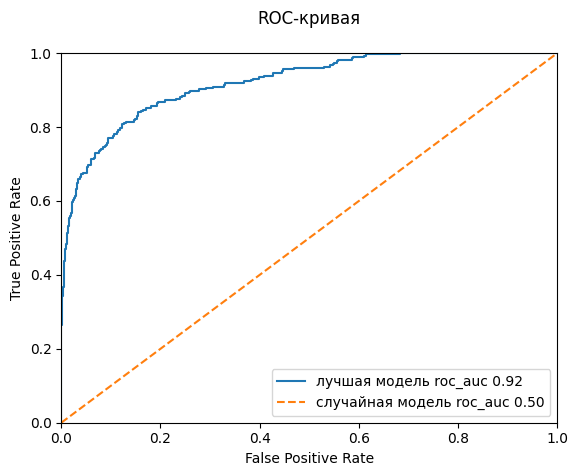

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(labels = ["лучшая модель roc_auc 0.92", "случайная модель roc_auc 0.50"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая" + "\n");

In [84]:
model_dummy = DummyClassifier(strategy="constant", constant=1)
model_dummy.fit(X_train, y_train)
predictions_dummy = model_dummy.predict(X_test)
print("accuracy наивной модели, предсказывающей, что все клиенты уйдут:", 
      round(accuracy_score(y_test, predictions_dummy), 2))

accuracy наивной модели, предсказывающей, что все клиенты уйдут: 0.16


Построенная модель показывает лучшие оценки, чем константная.

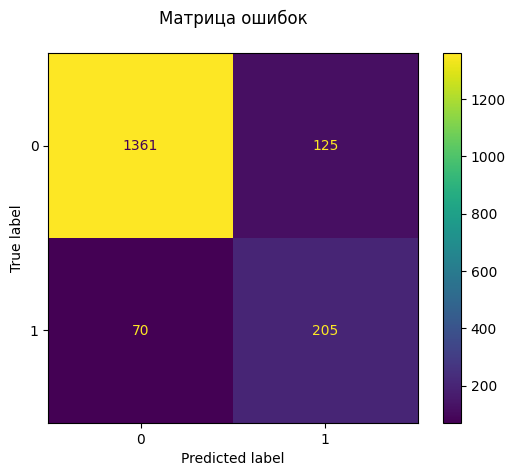

In [85]:
cm = confusion_matrix(y_test, predict_test, labels=model_cb.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cb.best_estimator_.classes_)
disp.plot()
plt.title("Mатрица ошибок" + "\n");

Модель ошибалась не часто, к тому же ошибок в случае клиент ушел - а модель посчитала, что нет, меньше всего, значит предсказания позволят принять своевременные меры по удержанию клиента.

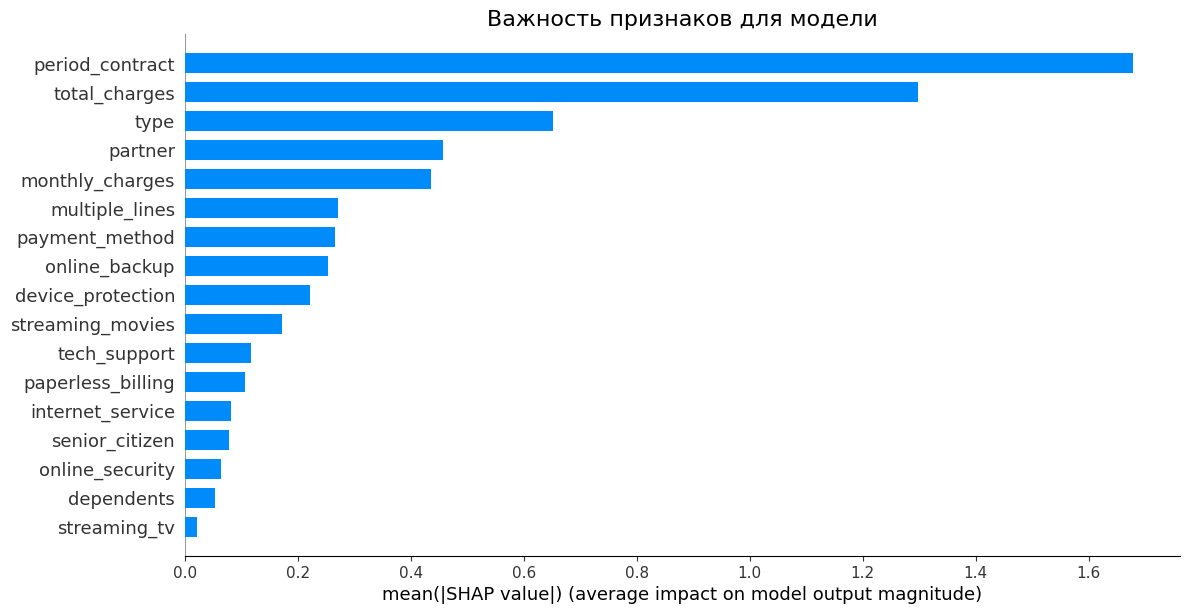

In [86]:
shap_test = shap.TreeExplainer(model_cb.best_estimator_["model"]).shap_values(X_test)
shap.summary_plot(shap_test, X_test, plot_type="bar", plot_size=(12, 6), show=False)
plt.title("Важность признаков для модели", fontsize=16)
plt.show()

**Вывод:** Выбранной модели CatBoost удалось достичь требуемого уровня качества на тестовом наборе данных, точность модели 89%, а roc_auc 0.92 (требовалось преодолеть значение 0.85). В случае, когда модель ошибается, чаще это будет ложно-позитивный ответ, чем ложно-негативный. Для модели самым важным признаком оказался период контракта, так и предполагалось. Траты клиента тоже важны, и тип оплаты договора. Все признаки в датасете косвенно определяют либо траты клиента (сами траты, наличие допов, тип интернета) все это указывает на то, что клиент платит больше, если платит больше, вероятнее уходит, либо период контракта (действующие клиенты уходят чаще новых или совсем старых). Наличие супруга оказалось весьма важно для модели.

## Отчет

**Примерный план решения задачи:**  
1. Исследование данных. Изучить взаимосвязь признаков с целевым признаком и между собой. Посмотреть особенности в данных, которые могут быть полезны для заказчика;
2. Обработка данных. Заполнить пропущенные значения и обработать аномалии в столбцах, изменить типы данных;
3. Подготовка признаков. Добавление новых признаков, если среди существующих признаков имеются неинформативные или вредные для модели, удалим их. Разделение данных на тренировочный и тестовый набор, кодирование (возможно масштабирование);
4. Обучение моделей. Подбор гиперпараметров для разных моделей. Сравнение на кросс-валидации;
5. Тестирование лучшей модели, сравнение с наивной моделью. Оформление отчета о работе.

**Итоговый план решения задачи:**  

По ходу работы над проектом удалось придерживаться намеченного плана решения задачи. Для достижения цели проекта не понадобилось дополнительных шагов.

**Трудности:**  

Общие затраты на услуги для новых клиентов, заключивших контракт в день выгрузки данных, не были заполнены. Заполнили общие затраты месячным платежом.

**Ключевые шаги в решении задачи:**  

Считаю ключевым шагом EDA, в ходе анализа данных были выявлены некоторые тенденции, которые нужно дополнительно рассмотреть в разных разрезах и с дополнительным набором данных.  
  
**Описание данных, использованных для обучения:**  

***Признаки***  
*period_contract* - разность *BeginDate* (дата начала пользования услугами) и *EndDate* (дата окончания пользования услугами),  
*TotalCharges* - всего потрачено денег на услуги,  
*Type* - тип оплаты: ежемесячный, годовой и двухгодичный,  
*Partner* - наличие супруга(и),  
*MonthlyCharges* - ежемесячные траты на услуги,  
*MultipleLines* - наличие возможности ведения параллельных линий во время звонка,  
*PaymentMethod* - способ оплаты,  
*OnlineBackup* - резервное копирование,  
*DeviceProtection* - защитное устройство,  
*StreamingMovies* - стримминговые фильмы,  
*TechSupport* - техподдержка,  
*PaperlessBilling* - безналичный расчет,  
*InternetService* - тип интенета: DSL, Fiber optic,  
*Senior Citizen* - наличие пенсионного статуса по возрасту,    
*OnlineSecurity* - онлайн безопасность,  
*Dependents* - наличие иждивенцев,   
*StreamingTV* - стримминговое ТВ.  

***Целевой признак***  
*off_contract* - выделен из признака *EndDate* (дата окончания пользования услугами), если дата не указана, значит клиент не ушел и его контракт действующий, факт ухода указан как положительный класс.

**Предобработка данных:** 

Данные состоят из файлов, полученных из разных источников:
- `***.csv` — информация о договоре,
- `***.csv` — персональные данные клиента,
- `***.csv` — информация об интернет-услугах,
- `***.csv` — информация об услугах телефонии.  

Для качественного анализа необходимо соединять эти данных в один датасет, используя уникальный номер клиента, на выходе каждая строчка, соединенного датасета представляет из себя информацию о каждом клиенте, его персональные данные, информацию о договоре, интернет-услугах и телефонии. Не все клиенты используют интернет-услуги и телефонию, поэтому файлы с информацией о них, содержат меньшее количество строк, при объединении файлов необходимо устранить пропуски и отметить, что клиент не использует услуги (мы указали это как "No"). В признаке multiple_lines пропуски означают отсутствие у клиента телефонии в целом, отметили как "No phone".  

В данных не был выделен целевой признак, факт ухода клиента, поэтому мы его выделили из даты окончания контракта, если даты нет, то клиент с нами. Сами даты начала и конца контракта не следует использовать для обучения. Год окончания однозначным образом определяет целевой признак. Год начала может негативно сказаться на модели на основе деревьев из-за их плохой масштабируемости, но для удобства анализа были выделены годы из этих дат, затем удалены. 

Обнаружены аномалии в столбце total_charges, общие затраты не заполнены по 11 контрактам, это контракты, которые успели оформить в день выгрузки, заполнили пропуски ежемесячным платежом, так как, клиент скорее всего платит вперед, возможно уже заплатил, а платеж не успел отобразиться в базе данных.  

Признак gender никак не влияет на целевой, поэтому мы не стали использовать его для обучения моделей. В этом можно убедиться рассмотрев корреляционную матрицу наших признаков, чем светлее поле, тем меньше связь признаков, и наоборот.
Высокой корреляции категориальных признаков между собой нет. Есть корреляция между streaming_tv и streaming_movies (чаще если у клиента есть стриминговое тв, то у него есть каталог фильмов, и наоборот), еще корреляция есть между столбцами с наличием супруга и наличием иждивенцев (если нет супруга, то и иждивенцев чаще нет, а если есть супруг, то примерно одинаково есть или нет). Среди числовых признаков (месячные, общие затраты и период контракта) сильнее связь у общих затрат с периодом контракта и месячным платежом, чем больше одно, тем больше и другое, наглядно изобразили на матрице сравнения распределения пар числовых признаков. Самое высокое влияние на целевой признак оказывает, созданный нами признак с периодом сотрудничества и общие затраты.

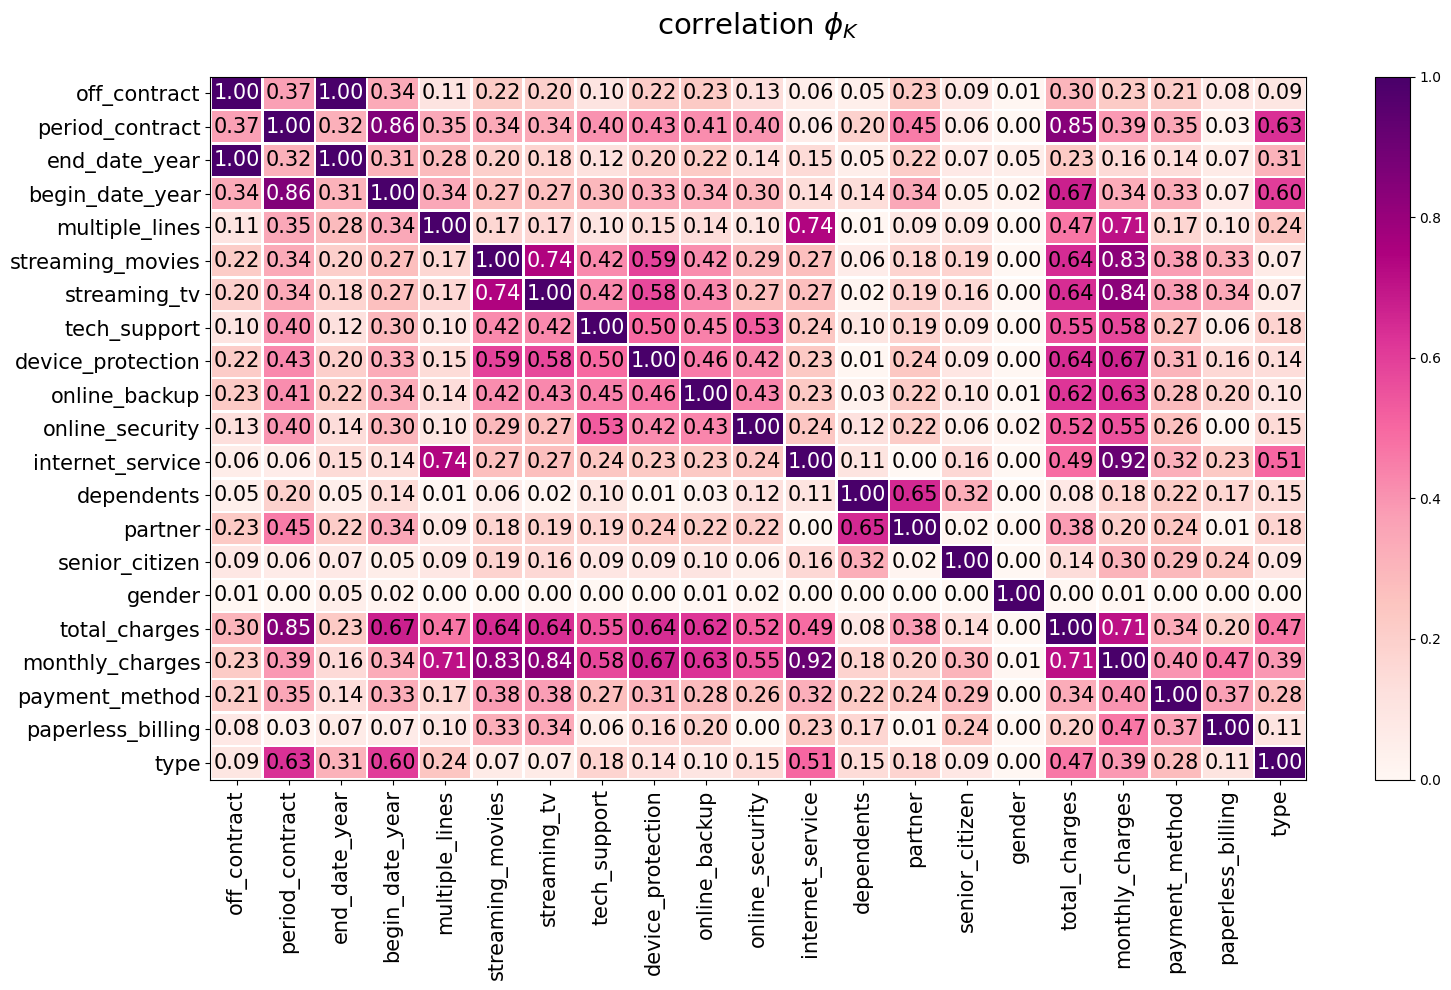

In [87]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="RdPu", 
                        title=r"correlation $\phi_K$" + "\n", 
                        fontsize_factor=1.5, 
                        figsize=(16, 10))

                               Сравнение распределения пар числовых признаков


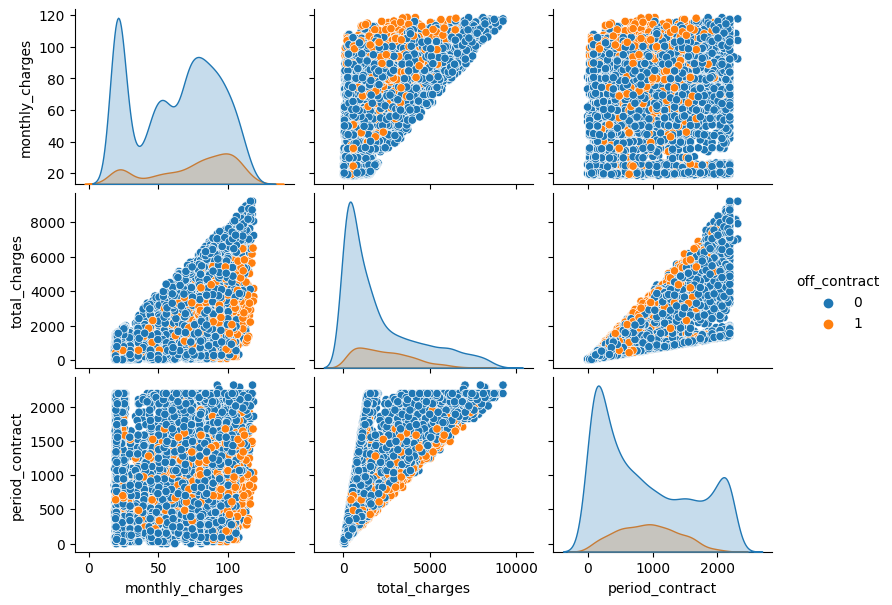

In [88]:
print(" "*30, "Сравнение распределения пар числовых признаков")
sns.pairplot(full_data[["monthly_charges", "total_charges", "period_contract", "off_contract"]], hue="off_contract")
plt.gcf().set_size_inches(9, 6);

**Анализ данных:**  

За весь период данных ушло 18,5% клиентов. С 2016 года количество новых клиентов растет, а в 2019 году пришло значительно больше клиентов, чем в предыдущие года. Уходят каждый год тоже больше клиентов.

Среди клиентов компании больше людей, не достигших пенсионного возраста, без супругов или иждивенцев. Клиенты предпочитают интернет, подключенный по оптоволоконному кабелю, и он значительно дороже, в основном не пользуются допами, а те, кто их использует - платят значительно больше. Больше выбирают способ оплаты - Electronic check, а также выставление счёта на электронную почту.

Мы можем видеть снижение количества длительных контрактов по типу, особенно двухгодичных за весь период данных, с 2014 к 2015 году снижение таких контрактов произошло в 3 раза, одногодичные снижаются с 2015 года. А также увеличение контрактов, оплачиваемых помесячно среди всех клиентов компании, от 2018 к 2019 году больше чем в два раза.

Средняя длительность контракта попрощавшегося клиента росла с 2014 до 2018 года, после значение примерно на одном уровне, если в 2014 году в среднем уходили клиенты с периодом сотрудничества меньше года, то уже в 2015 году больше года, в 2016, 2017 почти два и три года соответственно, а сейчас чуть больше трех лет.

Чаще уходят клиенты с длительным периодом действия договора, примерно через полтора года и до 4 с половиной лет, более новые или старые клиенты уходят реже. 

**Портрет уходящего клиента:**  

1.	тип договора - длительный,
2.	траты клиента - высокие, в том числе подключены доп.услуги (online security, online backup, device protection, tech support, streaming tv, streaming movies, multiple lines),
3.	способ оплаты - automatic (bank transfer или credit card),
4.	пенсионер, или есть супруг, или иждивенец.

Признак type
Month-to-month доля ушедших: 0.11
One year доля ушедших: 0.21
Two year доля ушедших: 0.22


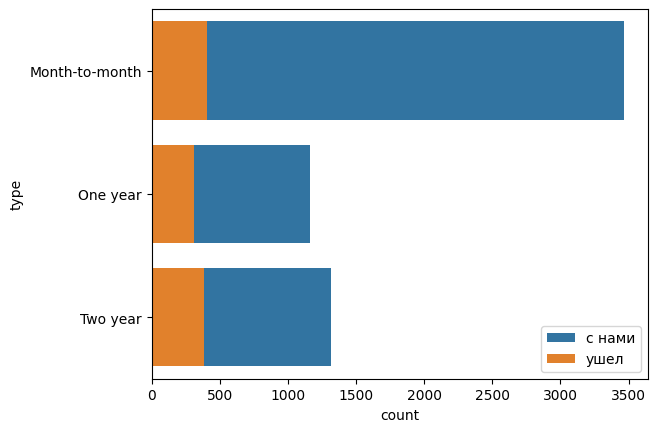

In [89]:
countplot_show ("type")

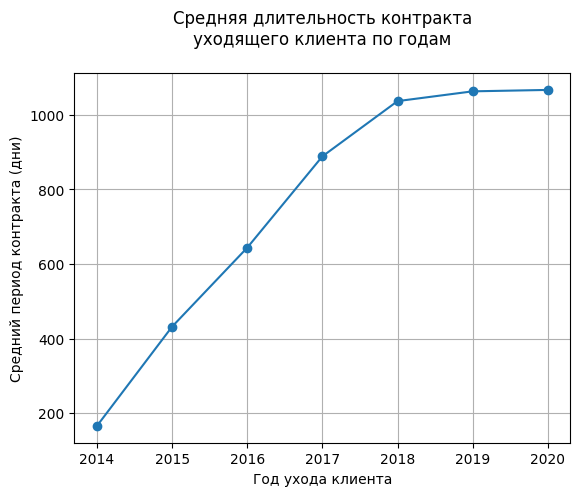

In [90]:
(
data_off
    .pivot_table(index="end_date_year", values="period_contract")
    .plot(style="o-", grid=True, legend=False)
)
plt.xlabel("Год ухода клиента")
plt.ylabel("Средний период контракта (дни)")
plt.title("Средняя длительность контракта" + "\n" + "уходящего клиента по годам" + "\n");

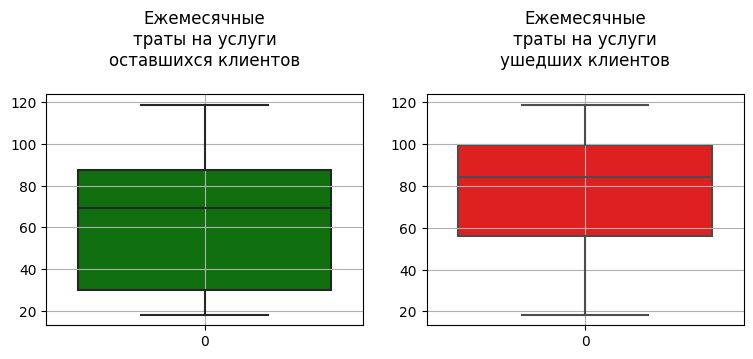

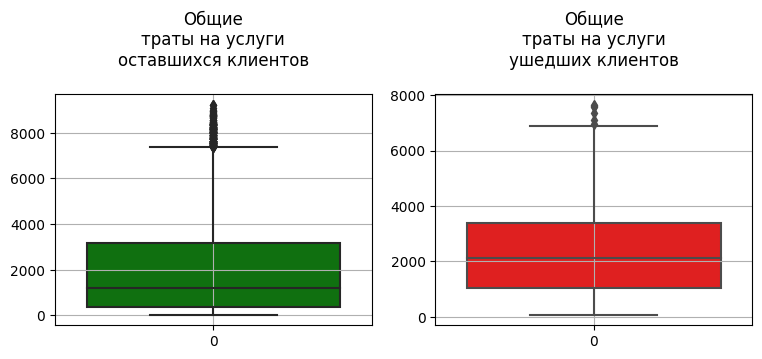

In [91]:
box_charges (data_on, data_off, "monthly_charges", "Ежемесячные")
box_charges (data_on, data_off, "total_charges", "Общие")

Признак payment_method
Electronic check доля ушедших: 0.15
Mailed check доля ушедших: 0.07
Bank transfer (automatic) доля ушедших: 0.21
Credit card (automatic) доля ушедших: 0.21


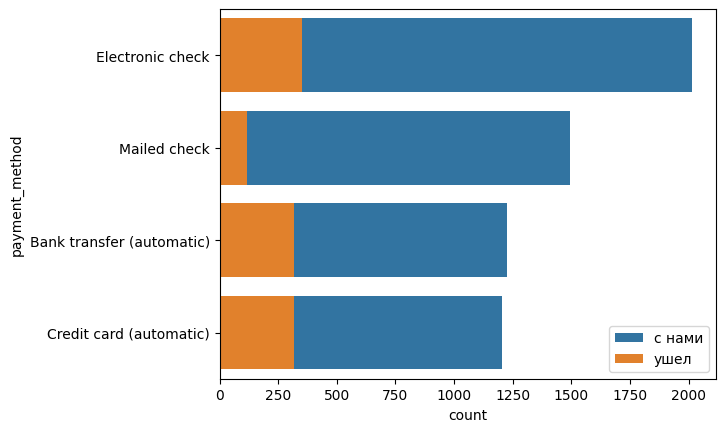

In [92]:
countplot_show ("payment_method")

Признак senior_citizen
No доля ушедших: 0.15
Yes доля ушедших: 0.2


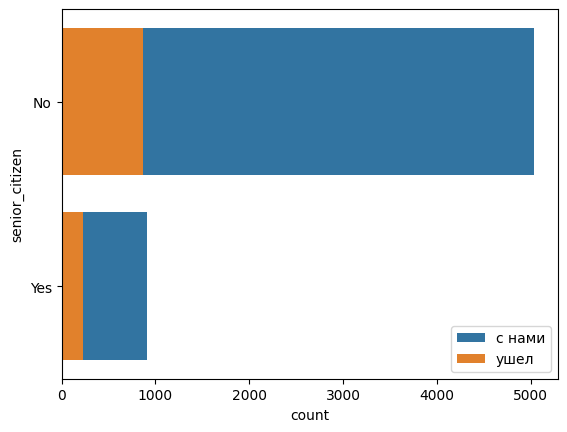

Признак partner
Yes доля ушедших: 0.21
No доля ушедших: 0.1


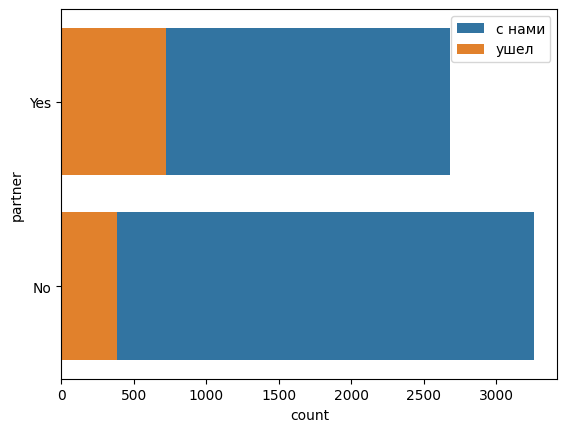

Признак dependents
No доля ушедших: 0.15
Yes доля ушедших: 0.17


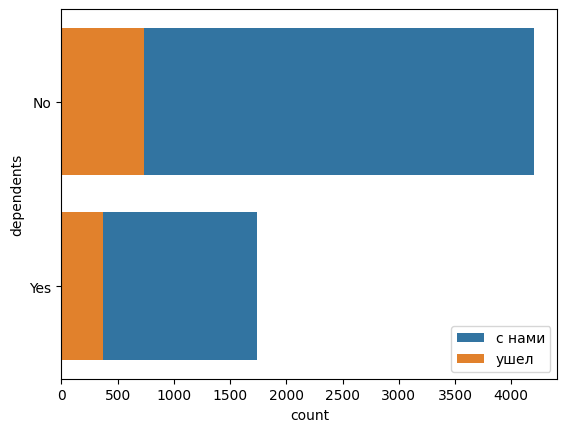

In [93]:
for col in ["senior_citizen", "partner", "dependents"]:
    countplot_show (col)

**Описание проверенных моделей**  

Данные были разделены на тренировочную и тестовую выборки, размер тестовой выборки 25%, при разделении был сохранен дисбаланс в целевом признаке (примерно 1:6), при помощи аргумента stratify метода train_test_split. Потому что у нас много категориальных признаков, было принято решение обучить бустинговые модели и случайный лес. Для случайного леса закодировали данные с помощью OneHotEncoder. Бустинговые модели умеют работать с категориями самостоятельно. Для подбора гиперпараметров использовали GridSearchCV и RandomizedSearchCV. Во избежание утечки данных во время кросс-валидации использовали Pipeline. Для борьбы с дисбалансом установили параметр class_weights = balanced, для корректного вычисления метрики accuracy, для целевой метрики roc_auc этот параметр не принципиален. Лучшей стала модель CatBoost, ее оценки выше, чем у остальных моделей, модель обучается дольше, чем близкая по оценкам LGBM, но все равно стоит остановиться на ней, обучается CatBoost тоже не слишком долго. Оценки моделей представлены в таблице.

In [94]:
mod.style.format("{:.2f}").highlight_max(color="yellowgreen", subset=["roc auc", "accuracy"])

,roc auc,accuracy,fit time
CatBoost,0.93,0.89,69.33
LGBM,0.90,0.88,2.09
RandomForest,0.82,0.82,4.11


**Финализирование выбора**  

Выбранной модели **CatBoost** удалось достичь требуемого уровня качества на тестовом наборе данных, точность модели 89%, а **roc_auc 0.92**. Параметры лучшей модели:
- auto_class_weights: 'Balanced',
- depth: 2,
- eval_metric: 'AUC',
- iterations: 1000,
- learning_rate: 0.3,
- logging_level: 'Silent'.  

Модель ошибалась не часто, к тому же ошибок в случае клиент ушел - а модель посчитала, что нет, меньше всего, значит предсказания позволят принять своевременные меры по удержанию клиента.  
Для модели самым важным признаком оказался период контракта. Траты клиента тоже важны, и тип оплаты договора, а также наличие супруга.

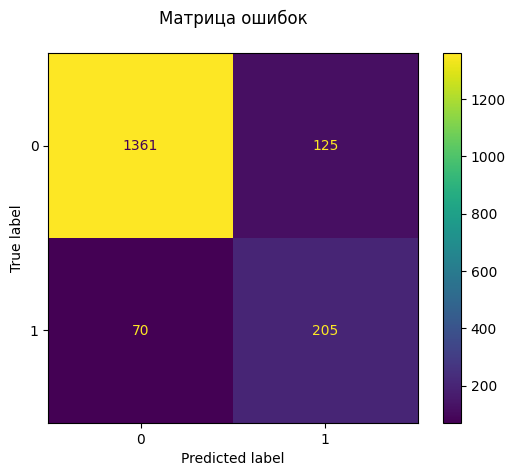

In [95]:
disp.plot()
plt.title("Mатрица ошибок" + "\n");

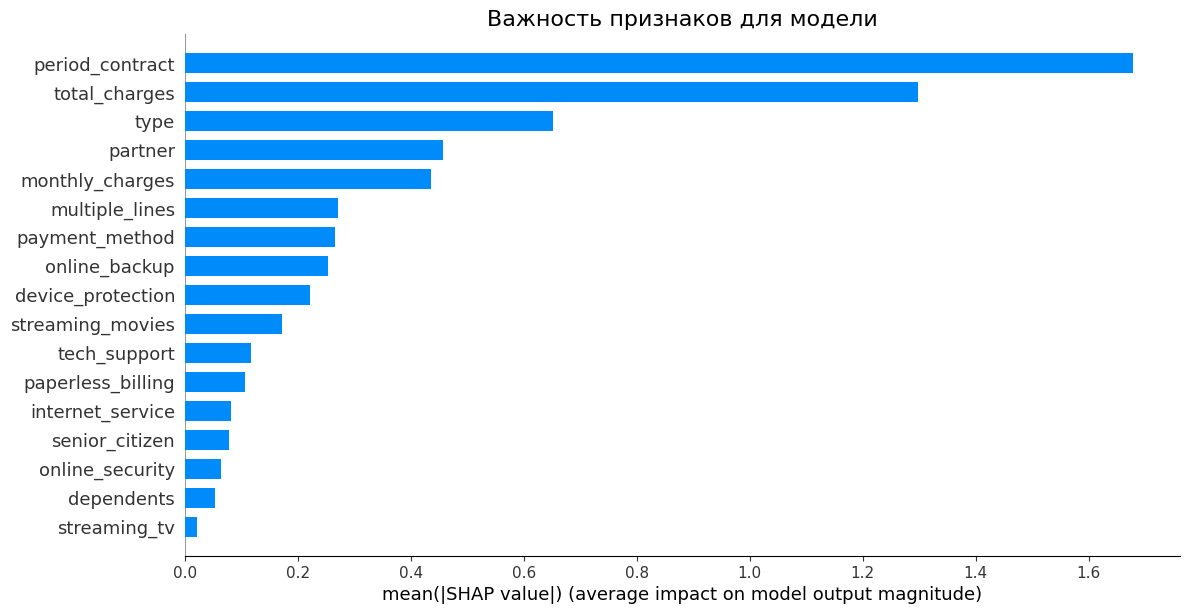

In [96]:
shap.summary_plot(shap_test, X_test, plot_type="bar", plot_size=(12, 6), show=False)
plt.title("Важность признаков для модели", fontsize=16)
plt.show()